In [1]:
import pandas as pd
import numpy as np

from scipy import stats, odr

from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

# Reading Cleaned Data

In [2]:
df = pd.read_pickle('data.pkl')

In [3]:
# Data types
df.dtypes

Sex           object
Event         object
Age          float64
Tested        object
Squat        float64
Bench        float64
Dead         float64
Total        float64
Weight        object
AgeGroup    category
dtype: object

# Removing Non Drug Tested Competitions

Data Exploration and Statistical Testing will be first performed separately and the results will be compared at the end.


In [4]:
df = df[df['Tested']=='Yes'].reset_index(drop = True)

# Stratifying Strength Data

Total = Weight of all three lifts combined (must have three at one competition)

Deadlift = Weight of maximum deadlift

Bench Press = Weight of maximum bench press

Squat = Weight of maximum squat

In [5]:
total = df[(df['Event']=='SBD')&\
          (df['Total'].notnull())&(df['Total']>0)].reset_index(drop = True)[['Sex','Age','Tested','Total','Weight','AgeGroup']].copy()

dead = df[(df['Dead'].notnull())&\
         (df['Dead']>0)].reset_index(drop = True)[['Sex','Age','Tested','Dead','Weight','AgeGroup']].copy()

bench = df[(df['Bench'].notnull())&\
          (df['Bench']>0)].reset_index(drop = True)[['Sex','Age','Tested','Bench','Weight','AgeGroup']].copy()

squat = df[(df['Squat'].notnull())&\
          (df['Squat']>0)].reset_index(drop = True)[['Sex','Age','Tested','Squat','Weight','AgeGroup']].copy()

# Modifying Population For "Average" Lifters
Average defined as a weight lifted between .25 and .75 quantile (IQR) of each weight group regardless of age

In [6]:
def average_weights(total):
    col = total.columns[3]
    btm = total.groupby('Weight')[col].quantile(.25).reset_index().copy() 
    btm.columns = ['Weight','Low']
    top = total.groupby('Weight')[col].quantile(.75).reset_index().copy() 
    top.columns = ['Weight','High']
    total = pd.merge(pd.merge(total,btm,
                              how = 'inner', on = 'Weight'),top, how = 'inner',on = 'Weight')
    total = total[(total[col]>=total['Low'])&(total[col]<=total['High'])].reset_index(drop = True).drop(['High','Low'], axis = 1)
    return total

In [7]:
total = average_weights(total) 
dead = average_weights(dead) 
squat = average_weights(squat) 
bench = average_weights(bench)

# Visualizations - Age, Weight, Strength

In [8]:
def quadrant(total,bench,squat,dead,sex,plot):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))

    axs[0,0].set_title('Age and Total Weight Lifted for '+sex)
    axs[0,1].set_title('Age and Bench Press for '+sex)
    axs[1,0].set_title('Age and Squat for '+sex)
    axs[1,1].set_title('Age and Deadlift for '+sex)

    common_xlim = (min(df['Age'])-10, max(df['Age'])+20)
    
    axs[0, 0].set_xlim(common_xlim)
    axs[0, 1].set_xlim(common_xlim)
    axs[1, 0].set_xlim(common_xlim)
    axs[1, 1].set_xlim(common_xlim)
    
    if plot == 'Scatter':
        sns.scatterplot(data=total[total['Sex'] == sex].copy(), x='Age', y='Total', color='steelblue', ax=axs[0, 0])
        sns.scatterplot(data=bench[bench['Sex'] == sex].copy(), x='Age', y='Bench', color='steelblue', ax=axs[0, 1])
        sns.scatterplot(data=squat[squat['Sex'] == sex].copy(), x='Age', y='Squat', color='steelblue', ax=axs[1, 0])
        sns.scatterplot(data=dead[dead['Sex'] == sex].copy(), x='Age', y='Dead', color='steelblue', ax=axs[1, 1])
        plt.tight_layout()
    elif plot == 'Box':
        sns.boxplot(data=total[total['Sex'] == sex].copy(), x='AgeGroup', y='Total', color='steelblue', ax=axs[0, 0])
        sns.boxplot(data=bench[bench['Sex'] == sex].copy(), x='AgeGroup', y='Bench', color='steelblue', ax=axs[0, 1])
        sns.boxplot(data=squat[squat['Sex'] == sex].copy(), x='AgeGroup', y='Squat', color='steelblue', ax=axs[1, 0])
        sns.boxplot(data=dead[dead['Sex'] == sex].copy(), x='AgeGroup', y='Dead', color='steelblue', ax=axs[1, 1])
        plt.tight_layout()

Sex = M

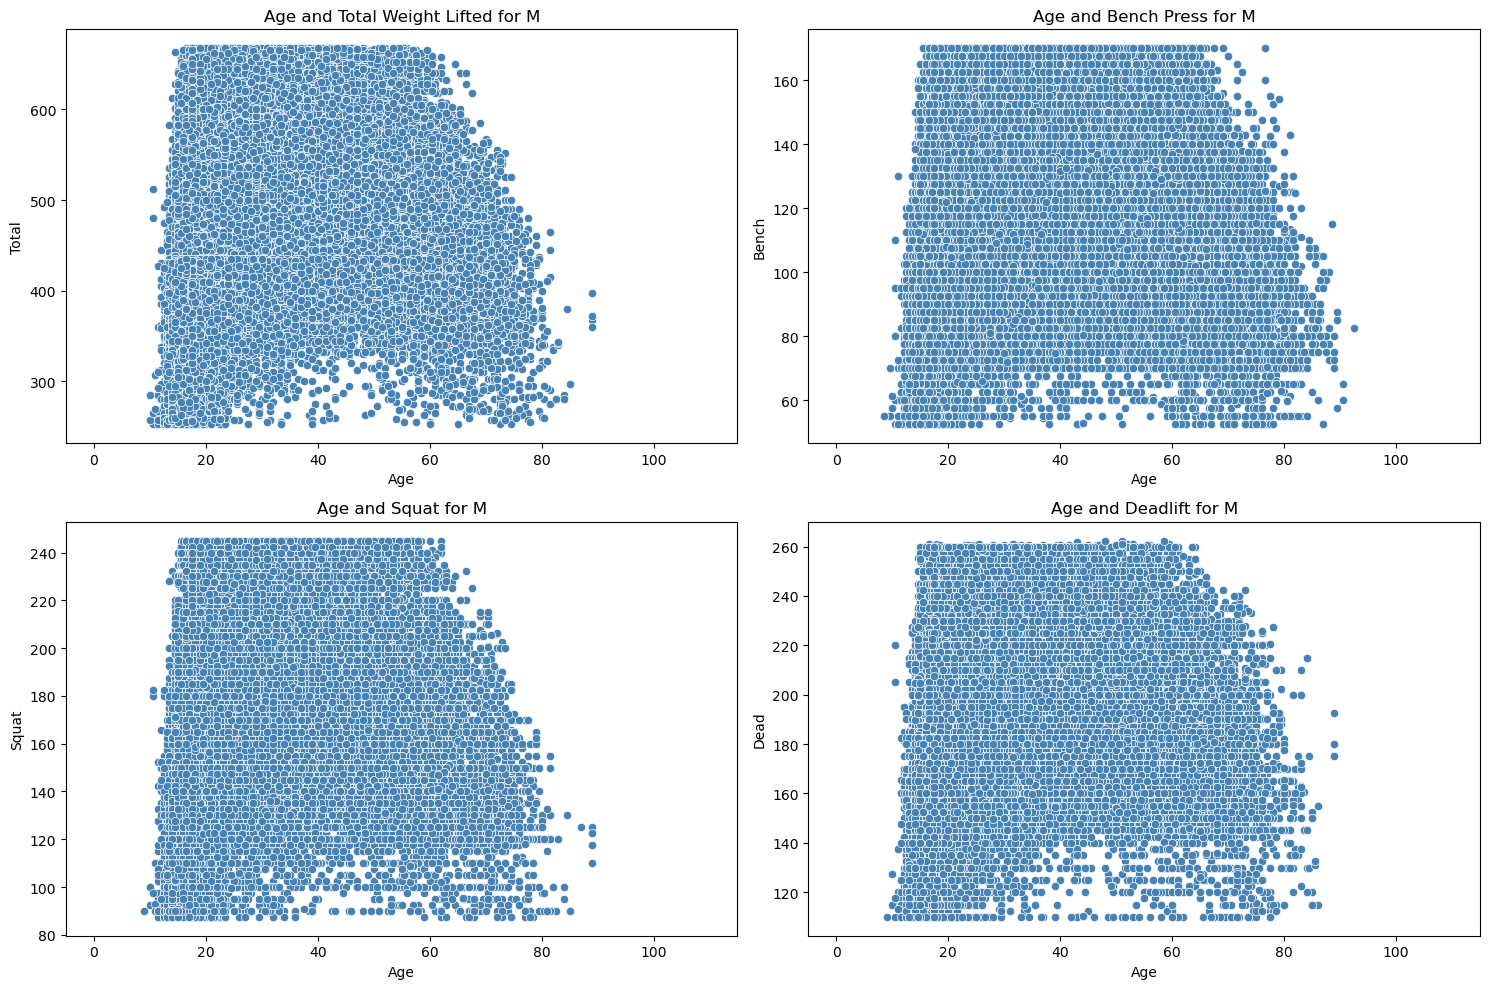

In [9]:
quadrant(total,bench,squat,dead,'M','Scatter')

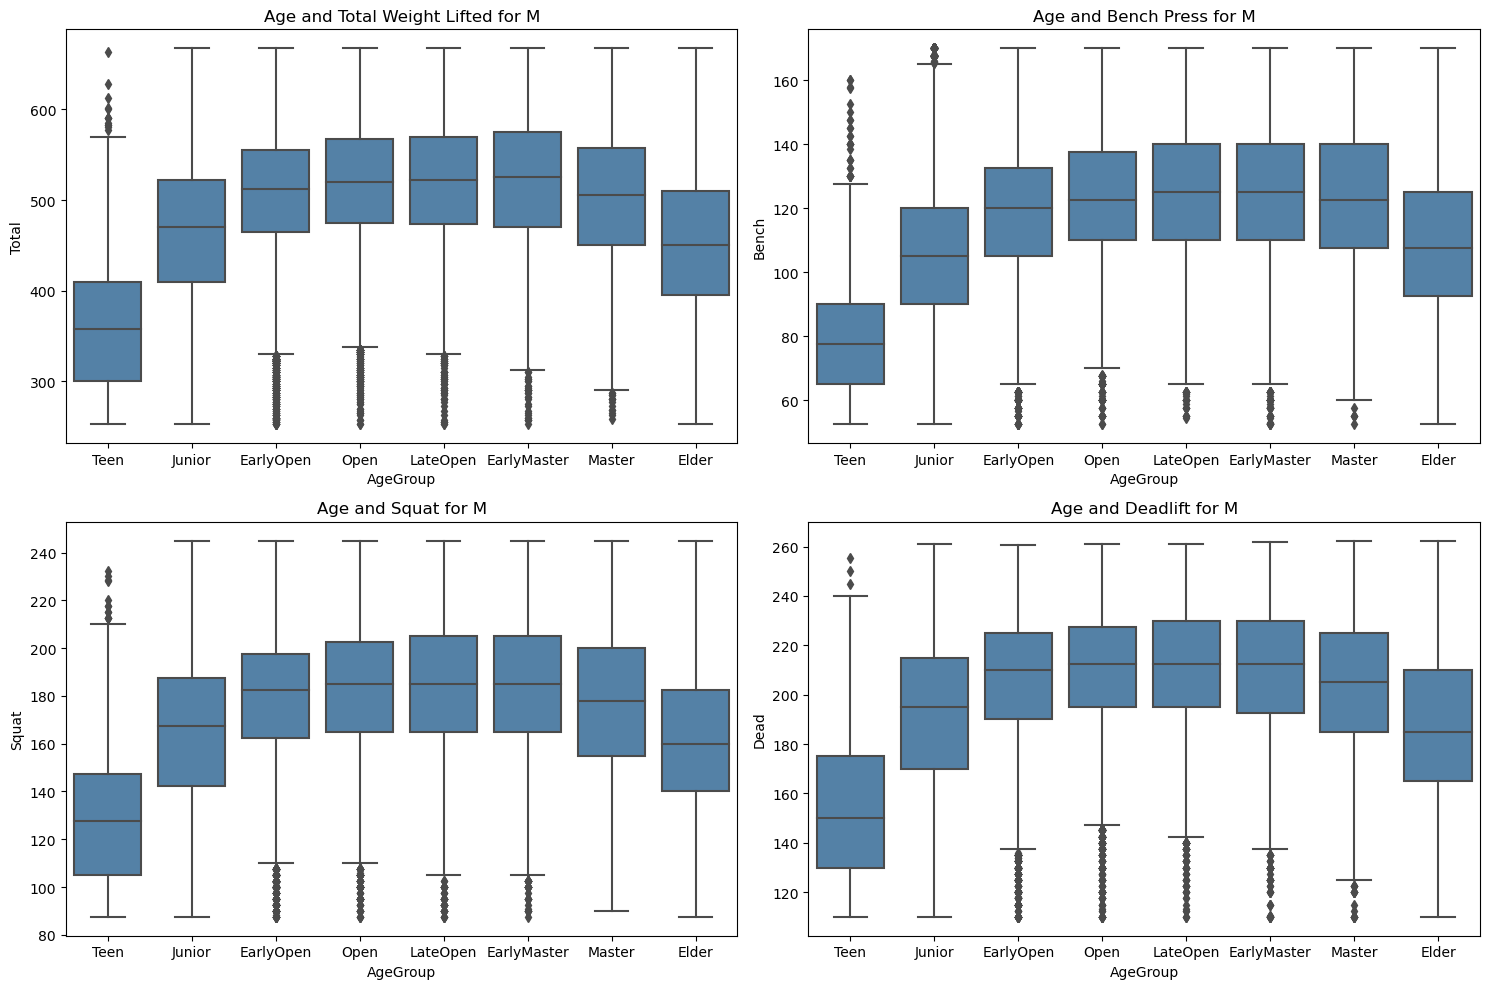

In [10]:
quadrant(total,bench,squat,dead,'M','Box')

Sex = F

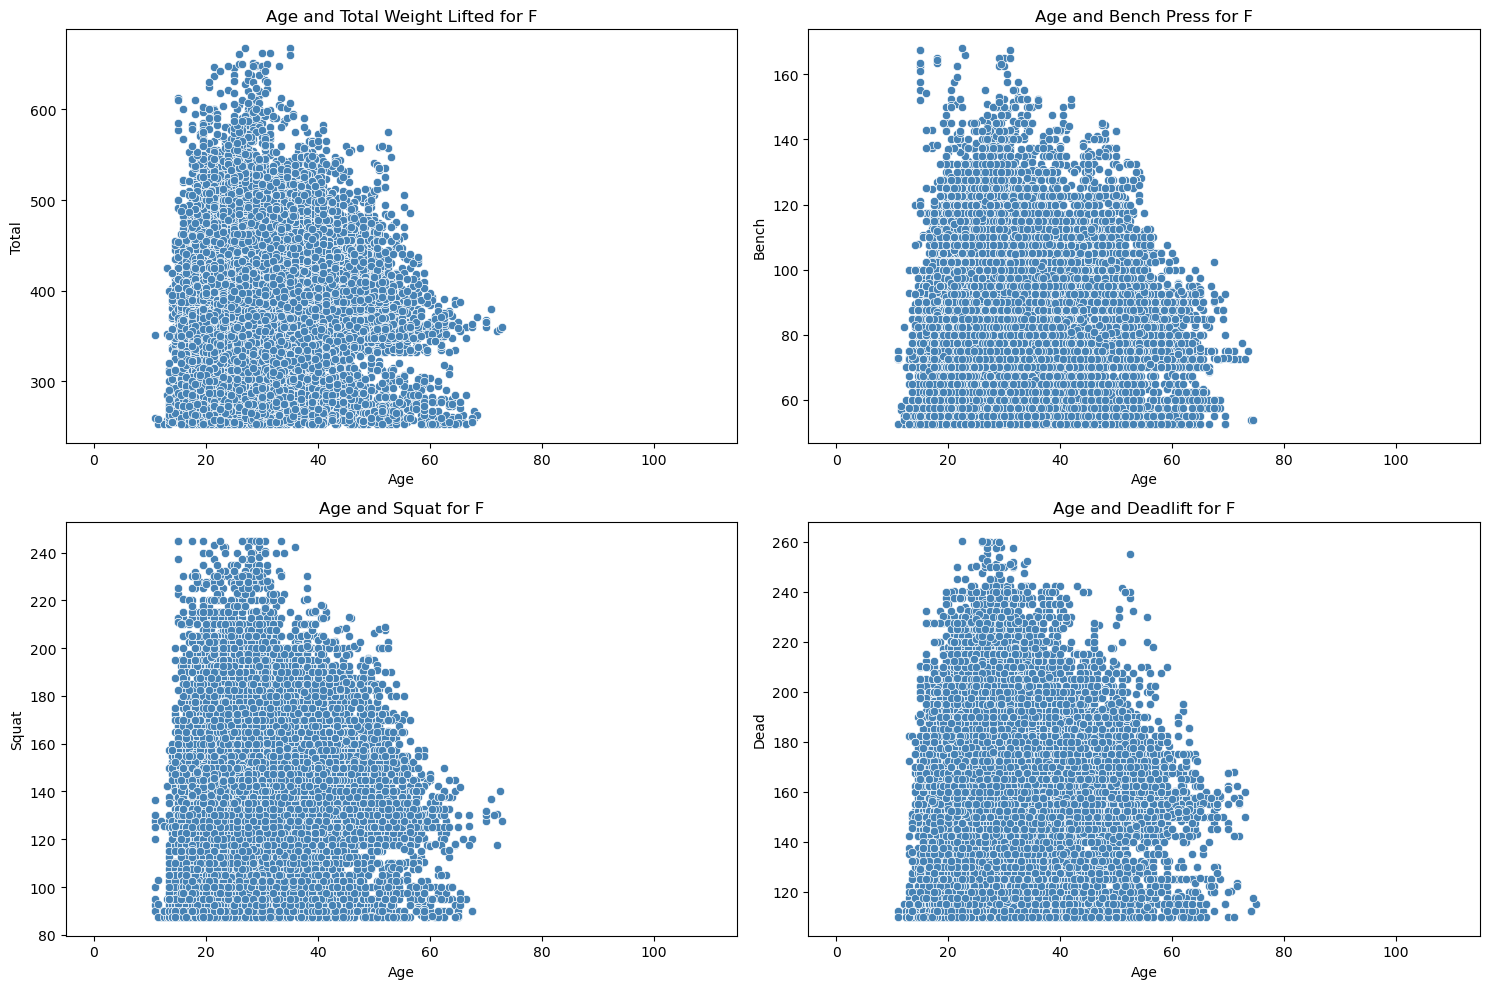

In [11]:
# Female
quadrant(total,bench,squat,dead,'F','Scatter')

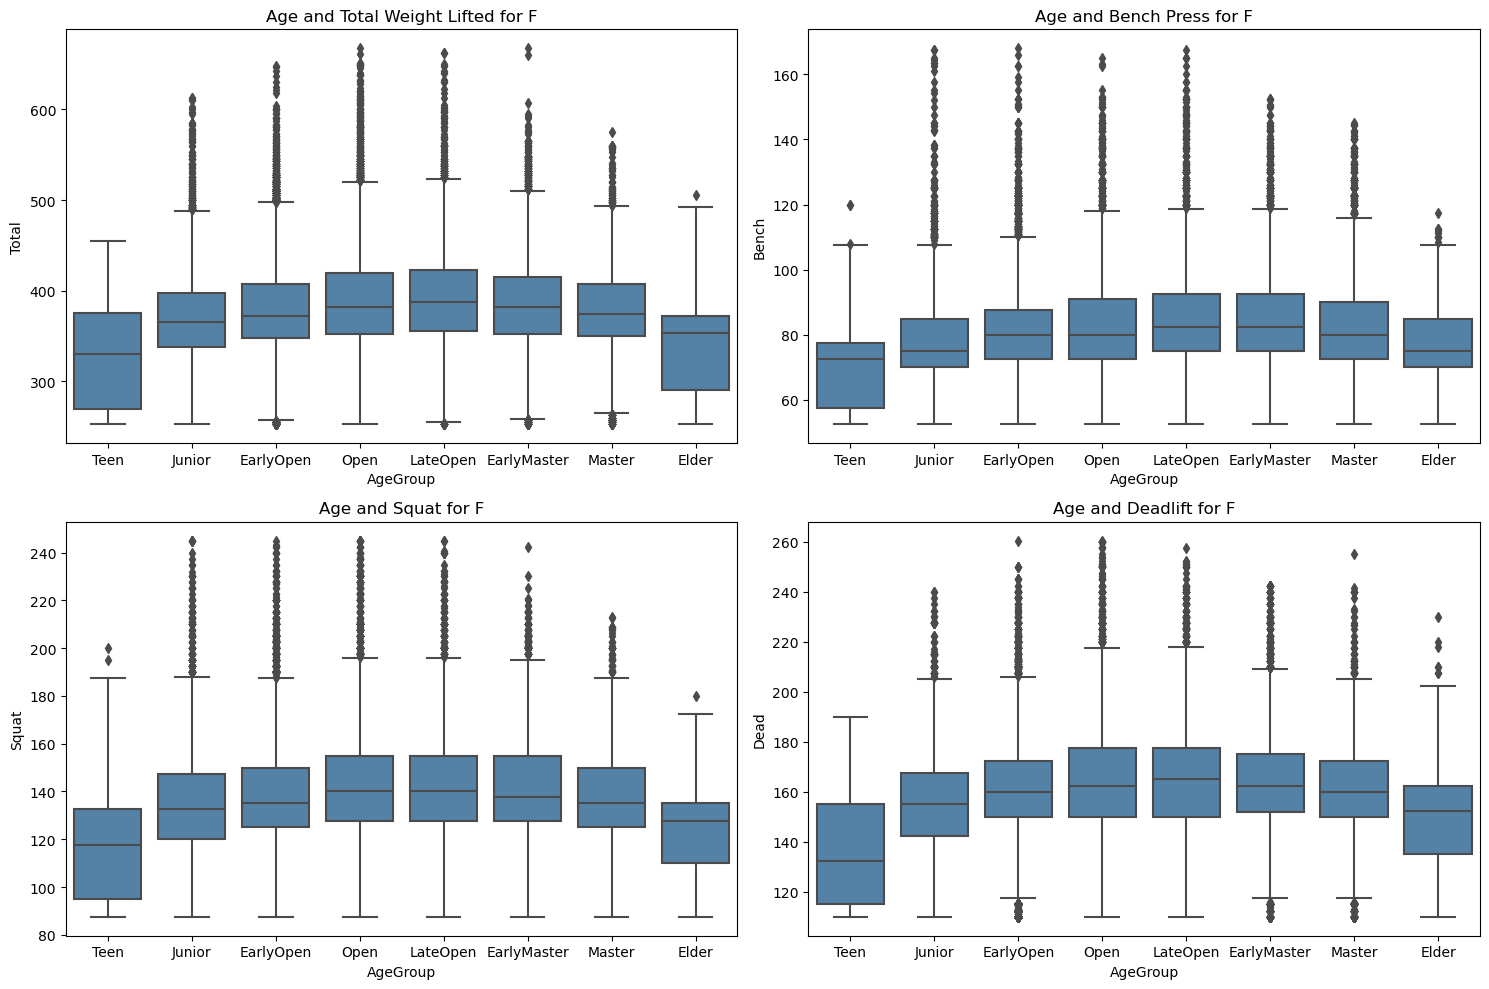

In [12]:
quadrant(total,bench,squat,dead,'F','Box')

Take a random sample for each age group

In [13]:
age_groups = df['AgeGroup'].unique()

def sample(total, n):
    dfs = pd.DataFrame()
    for x in range(len(age_groups)):
        a = total[total['AgeGroup']==age_groups[x]].copy()
        aa = a.sample(n = 500).copy()
        dfs = pd.concat([dfs,aa], axis = 0, ignore_index = True)
    return dfs

Sex = M

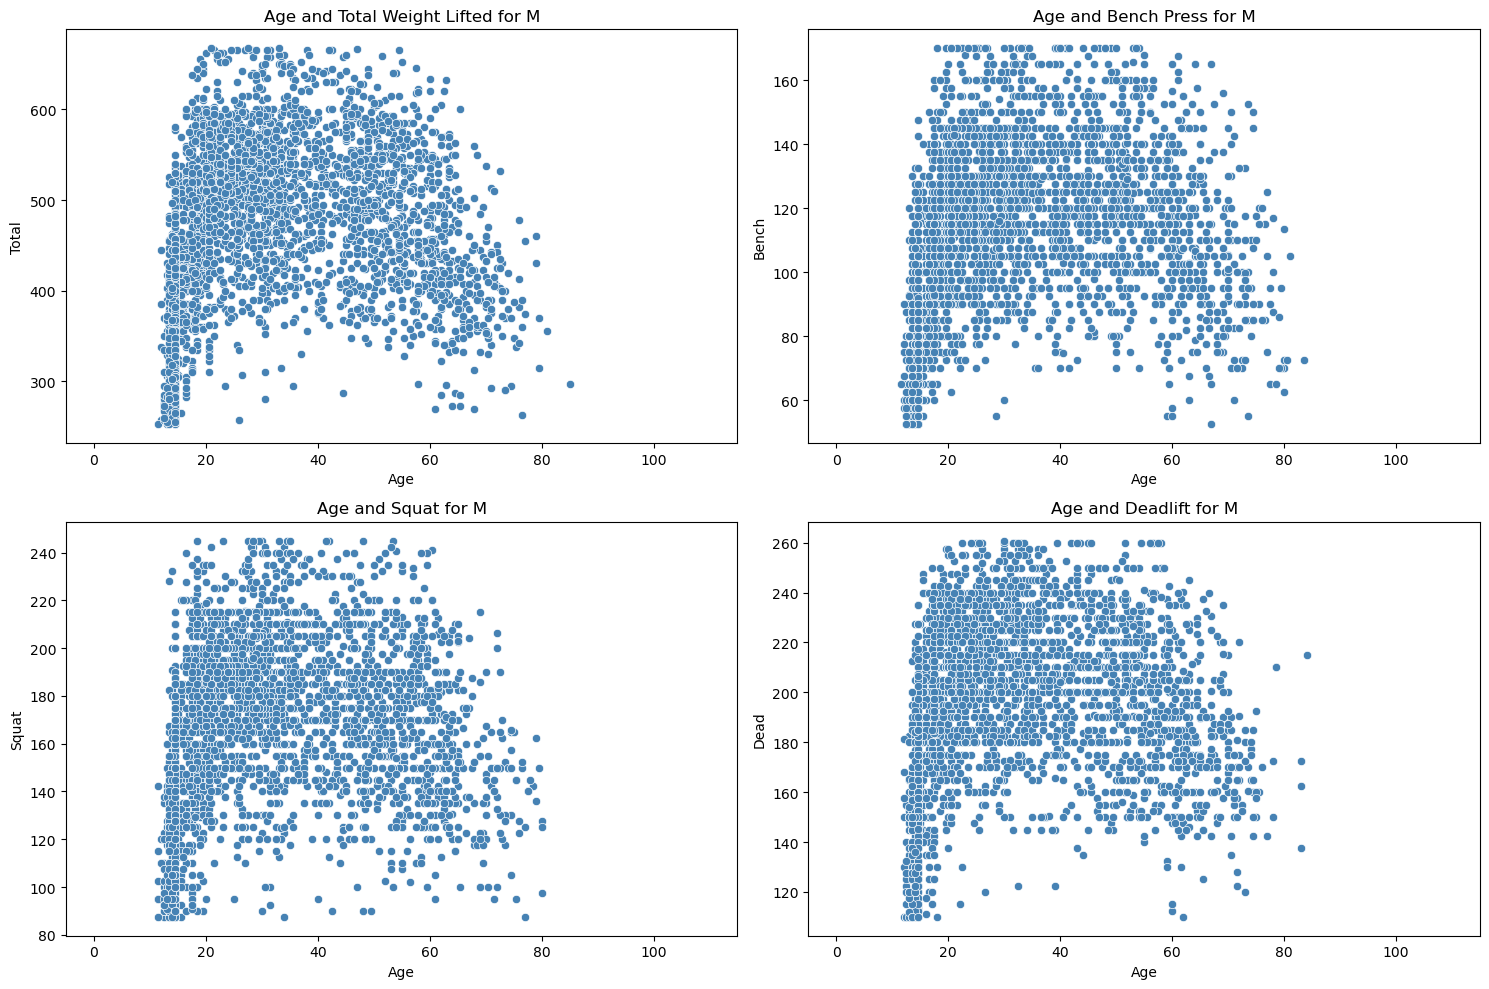

In [14]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Scatter')

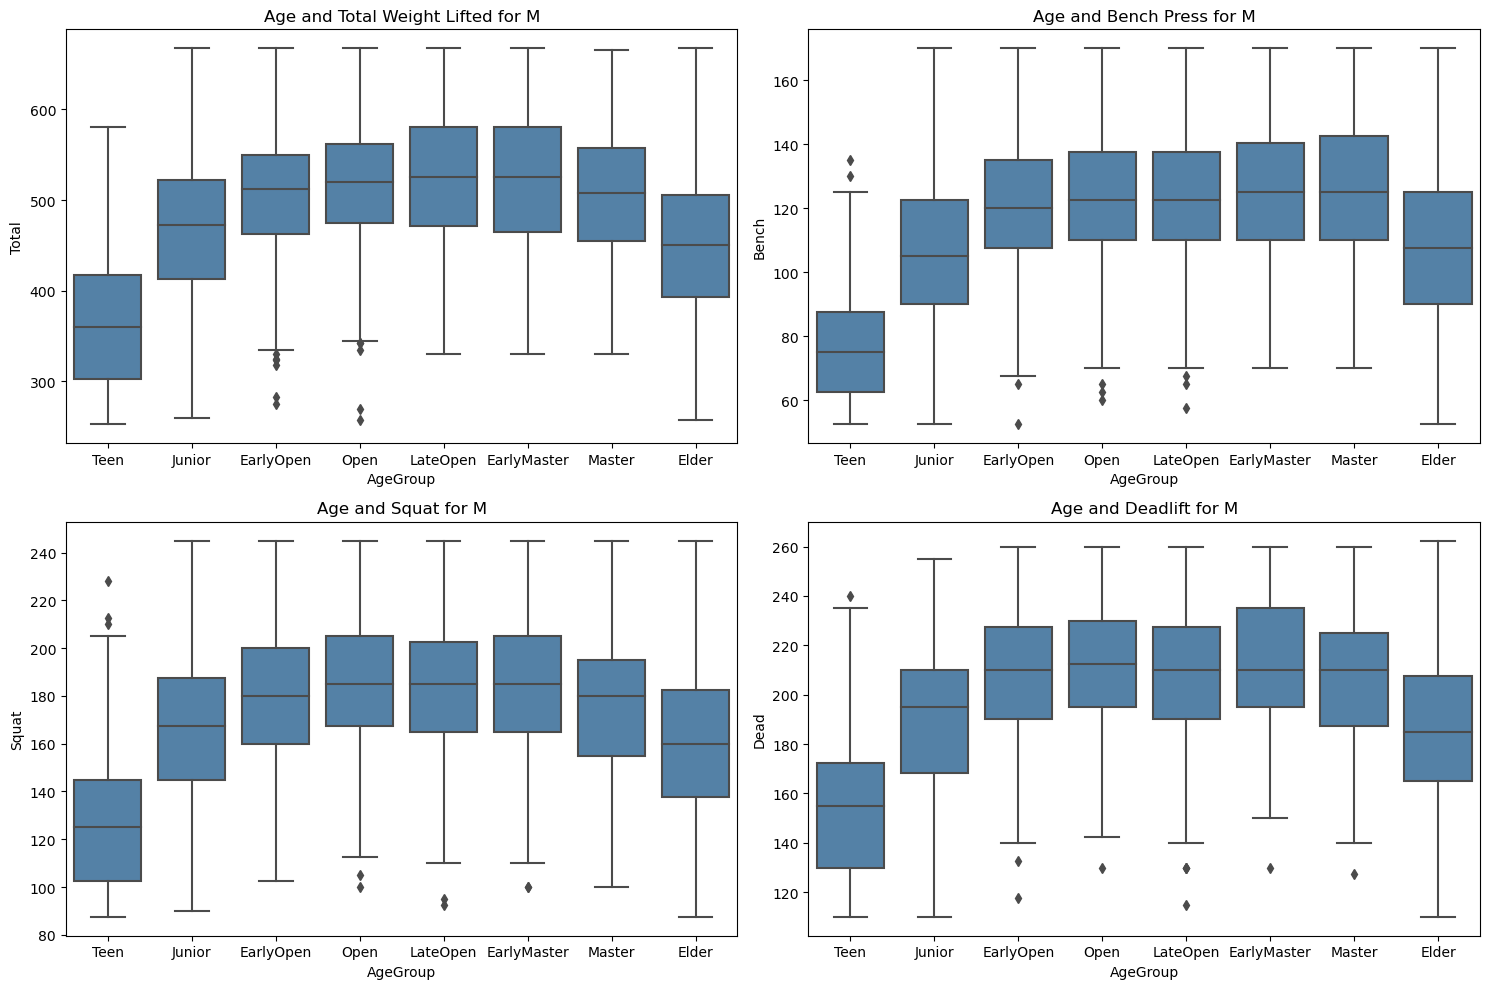

In [15]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Box')

Sex = F

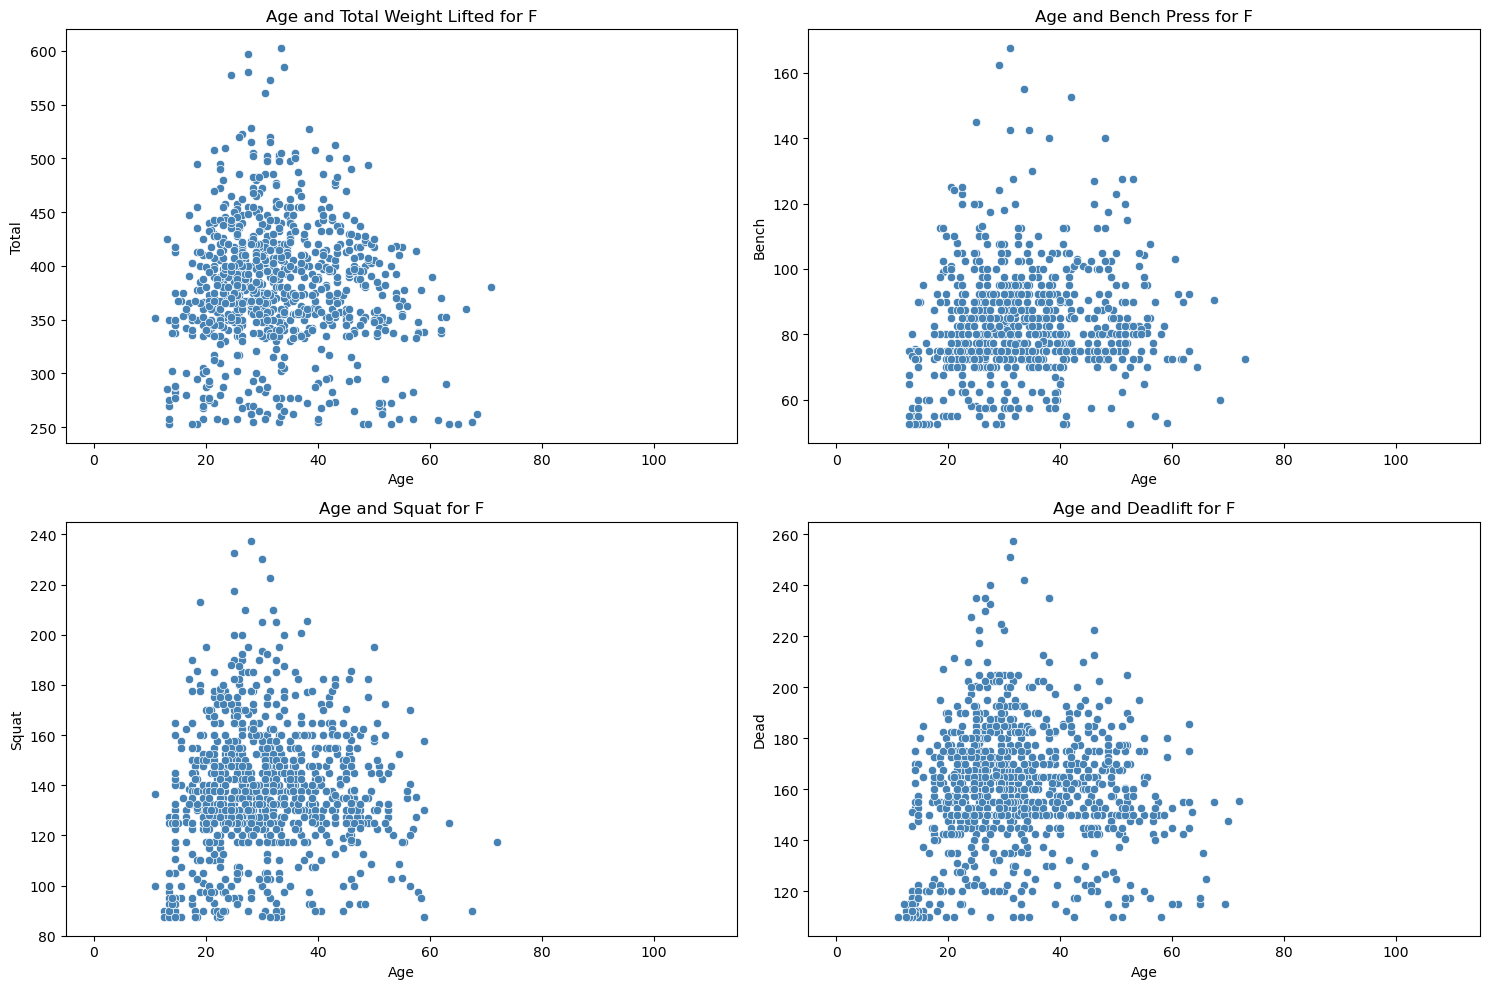

In [16]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Scatter')

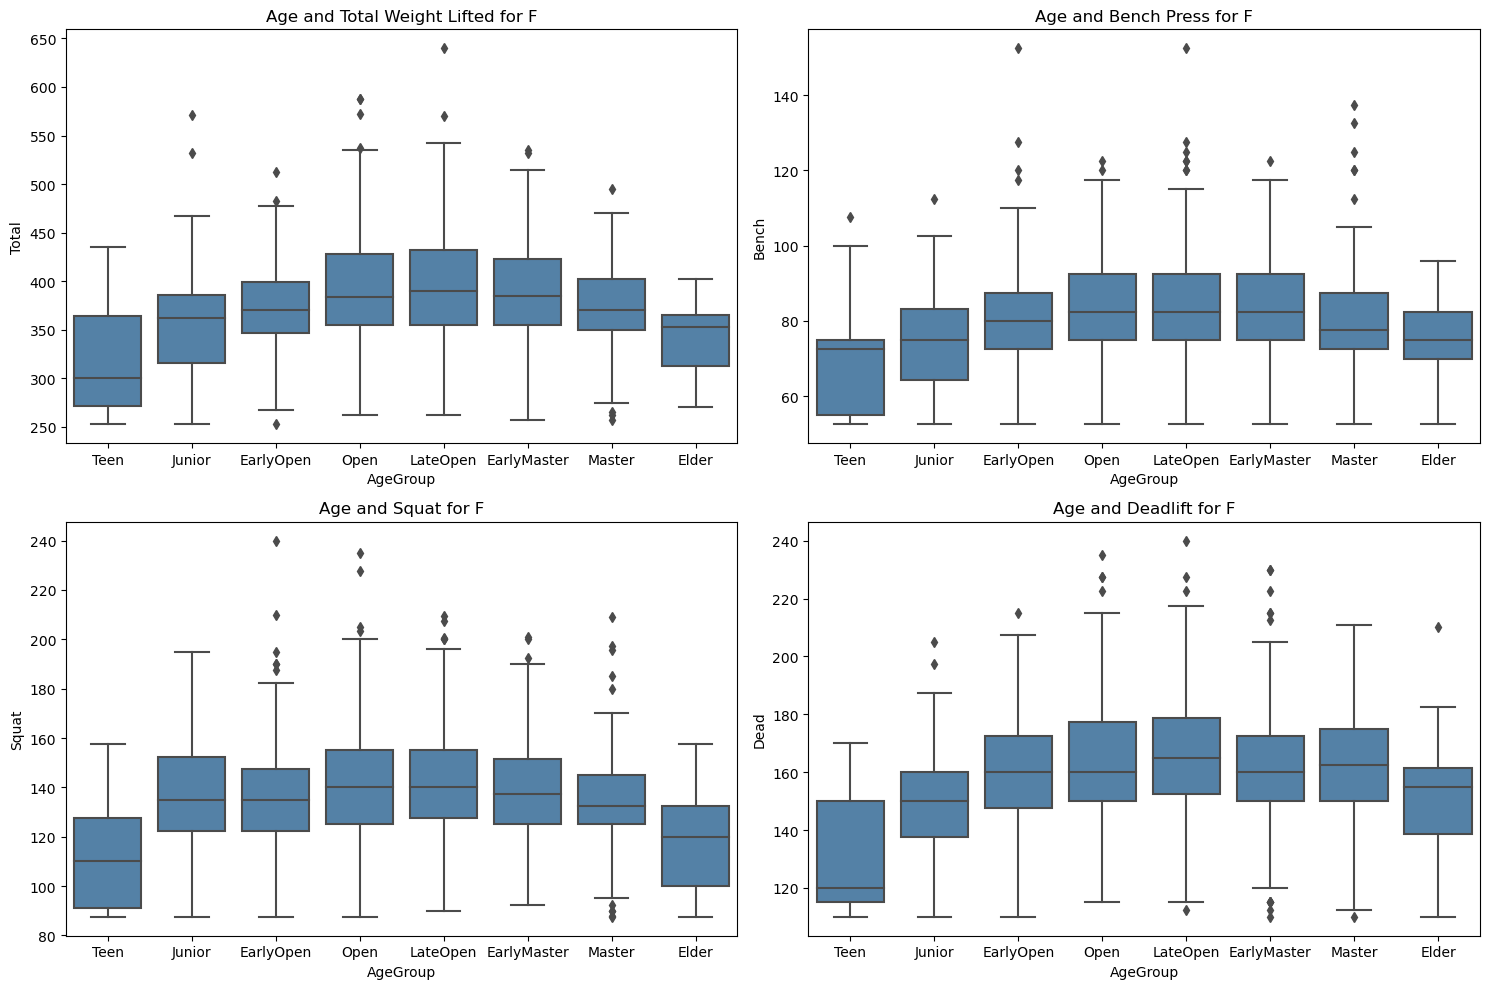

In [17]:
quadrant(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Box')

Random Selected Sample Scatter Plot with Hue

In [18]:
def quadrant_hue(total,bench,squat,dead,sex,hue,group):
    fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
    if group == 'Lighter':
        total = total[total['Weight'].isin(['Light','Middle'])]
        dead = dead[dead['Weight'].isin(['Light','Middle'])]
        squat = squat[squat['Weight'].isin(['Light','Middle'])]
        bench = bench[bench['Weight'].isin(['Light','Middle'])]
    elif group == 'Heavier':
        total = total[total['Weight'].isin(['Heavy','SuperHeavy'])]
        dead = dead[dead['Weight'].isin(['Heavy','SuperHeavy'])]
        squat = squat[squat['Weight'].isin(['Heavy','SuperHeavy'])]
        bench = bench[bench['Weight'].isin(['Heavy','SuperHeavy'])]
    
    axs[0,0].set_title('Age and Total Weight Lifted for '+sex)
    axs[0,1].set_title('Age and Bench Press for '+sex)
    axs[1,0].set_title('Age and Squat for '+sex)
    axs[1,1].set_title('Age and Deadlift for '+sex)

    common_xlim = (min(df['Age'])-10, max(df['Age'])+20)
    
    axs[0, 0].set_xlim(common_xlim)
    axs[0, 1].set_xlim(common_xlim)
    axs[1, 0].set_xlim(common_xlim)
    axs[1, 1].set_xlim(common_xlim)

    hue_order = total[hue].unique()

    palette = sns.color_palette('Accent', n_colors=len(hue_order))

    sns.scatterplot(data=total[total['Sex'] == sex].copy(), x='Age', y='Total', ax=axs[0, 0],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=bench[bench['Sex'] == sex].copy(), x='Age', y='Bench', ax=axs[0, 1],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=squat[squat['Sex'] == sex].copy(), x='Age', y='Squat', ax=axs[1, 0],
                    hue=hue, palette=palette, hue_order=hue_order)
    sns.scatterplot(data=dead[dead['Sex'] == sex].copy(), x='Age', y='Dead', ax=axs[1, 1],
                    hue=hue, palette=palette, hue_order=hue_order)
    plt.tight_layout()

Sex = M

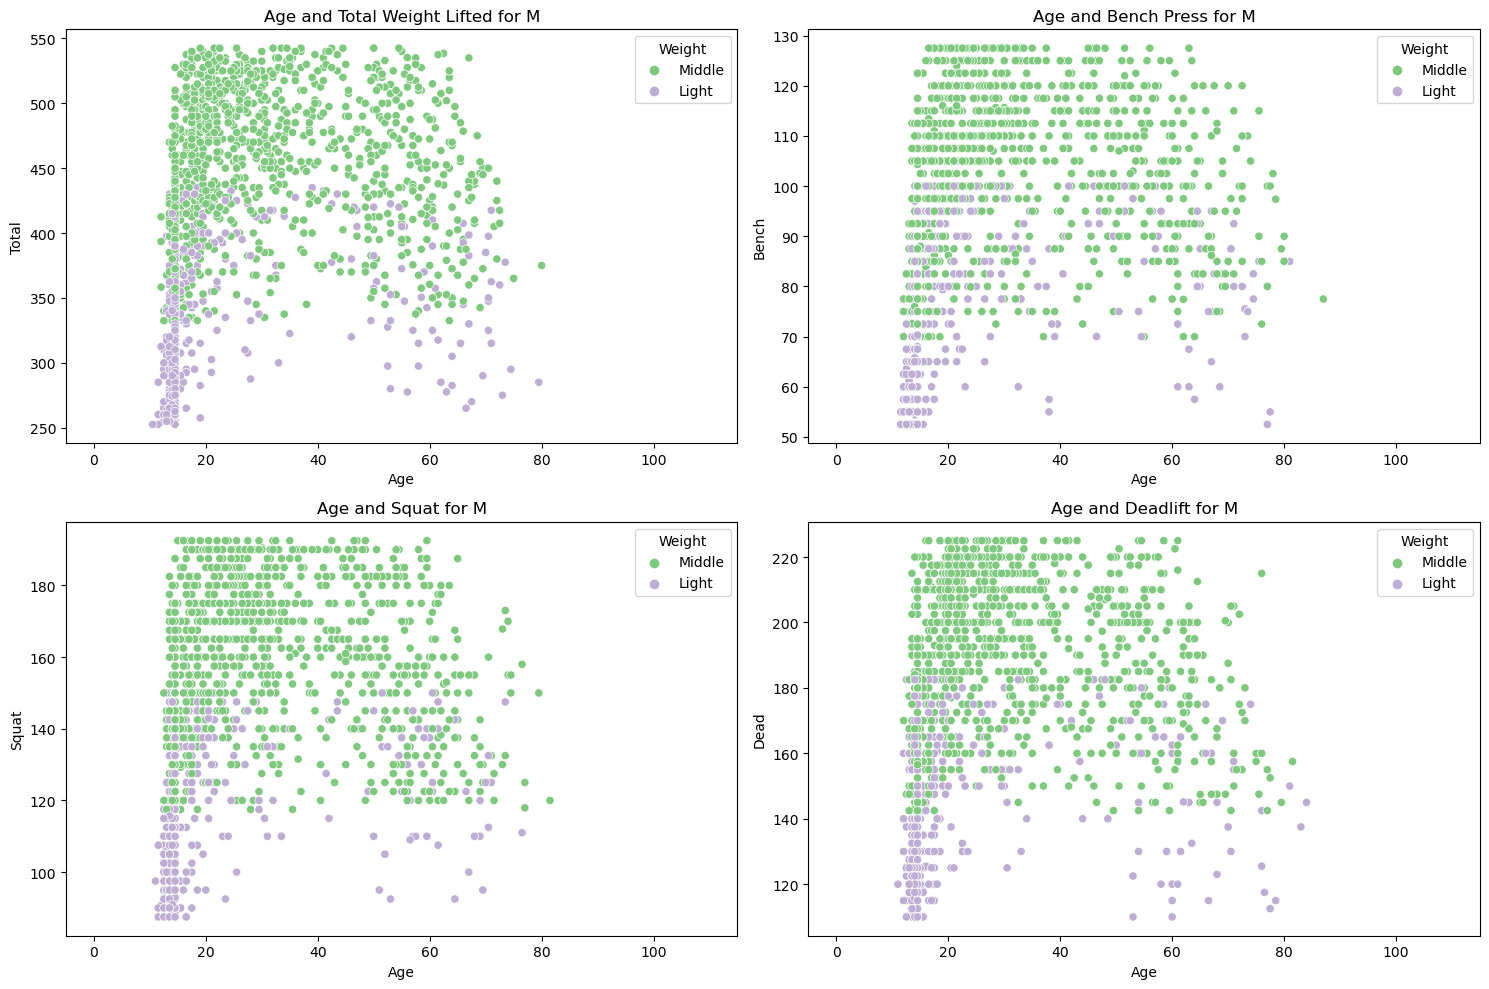

In [19]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Weight','Lighter')

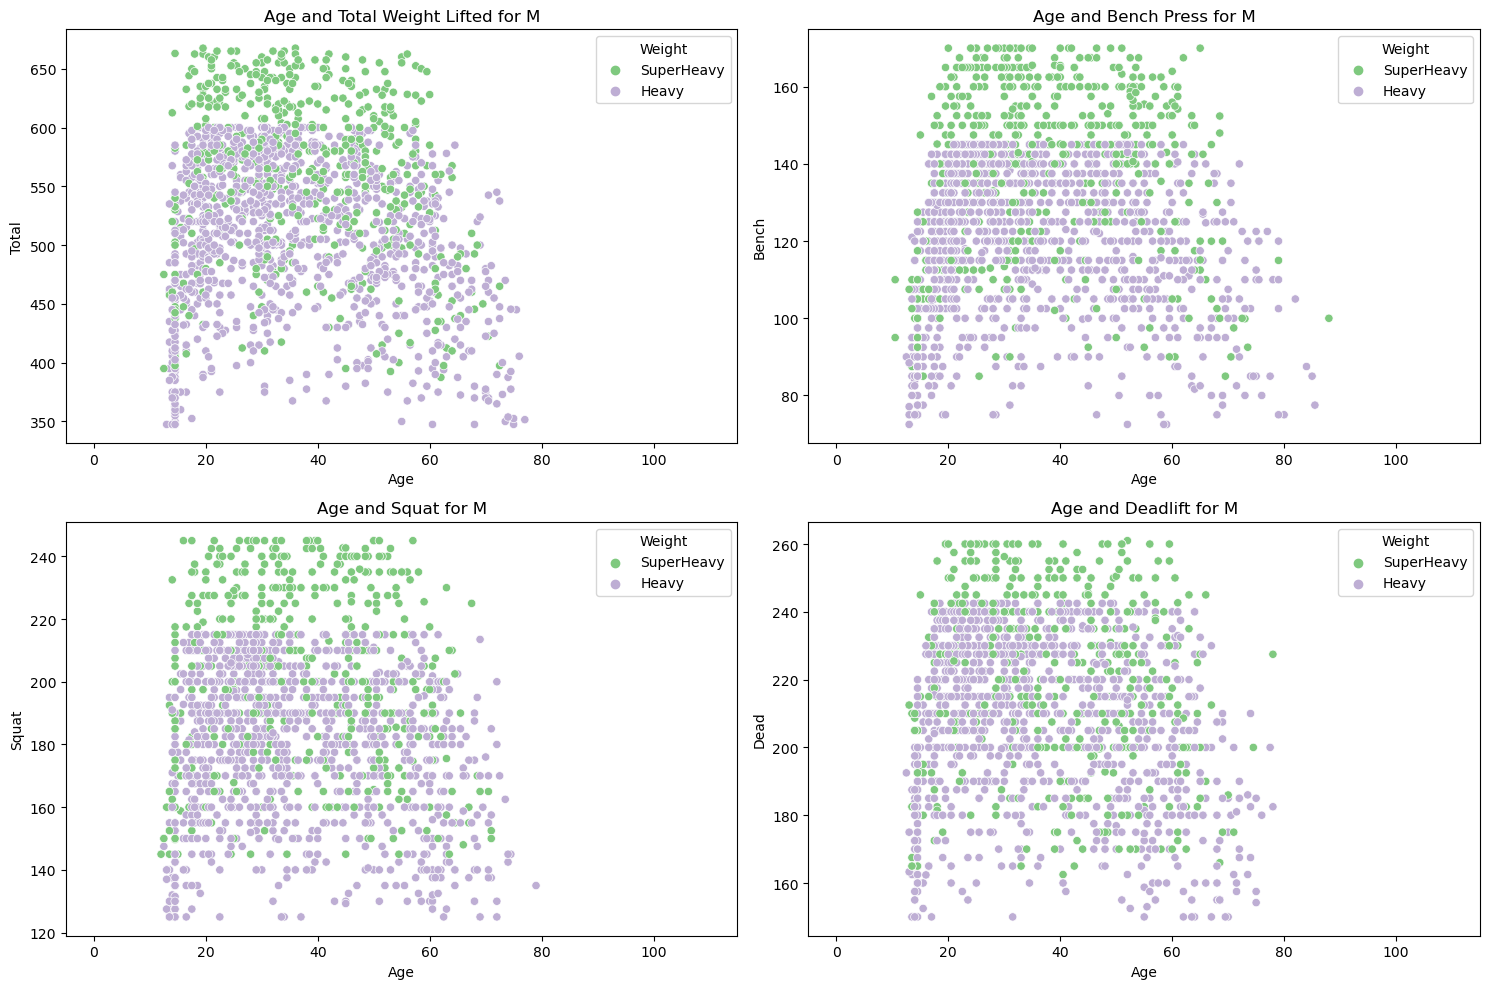

In [20]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'M','Weight','Heavier')

Sex = F

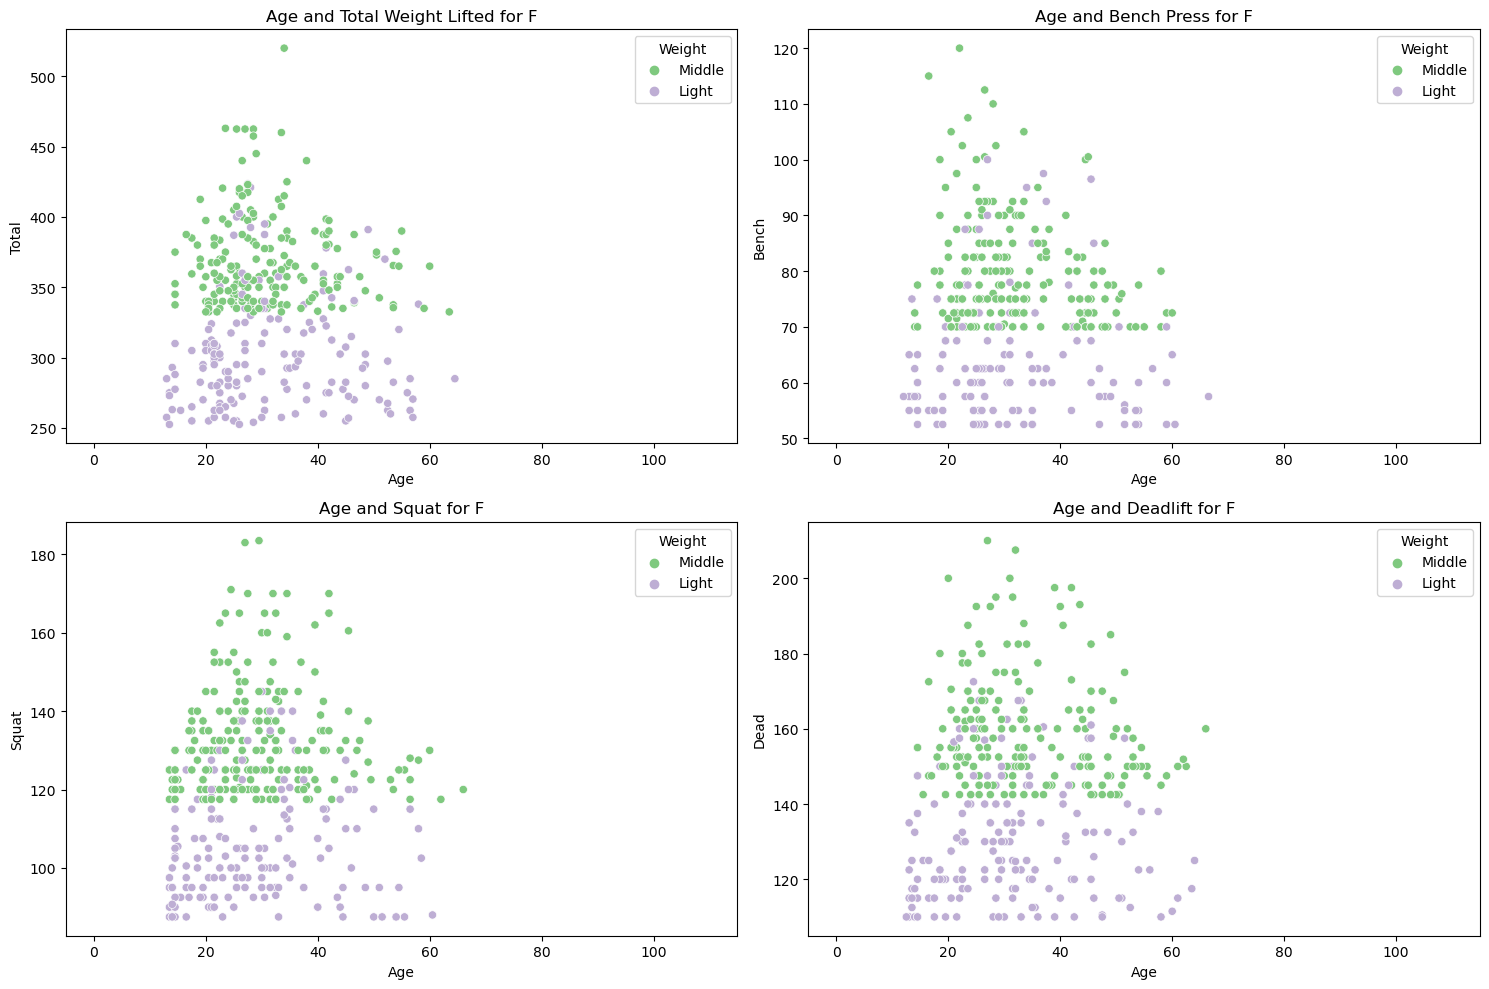

In [21]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Weight','Lighter')

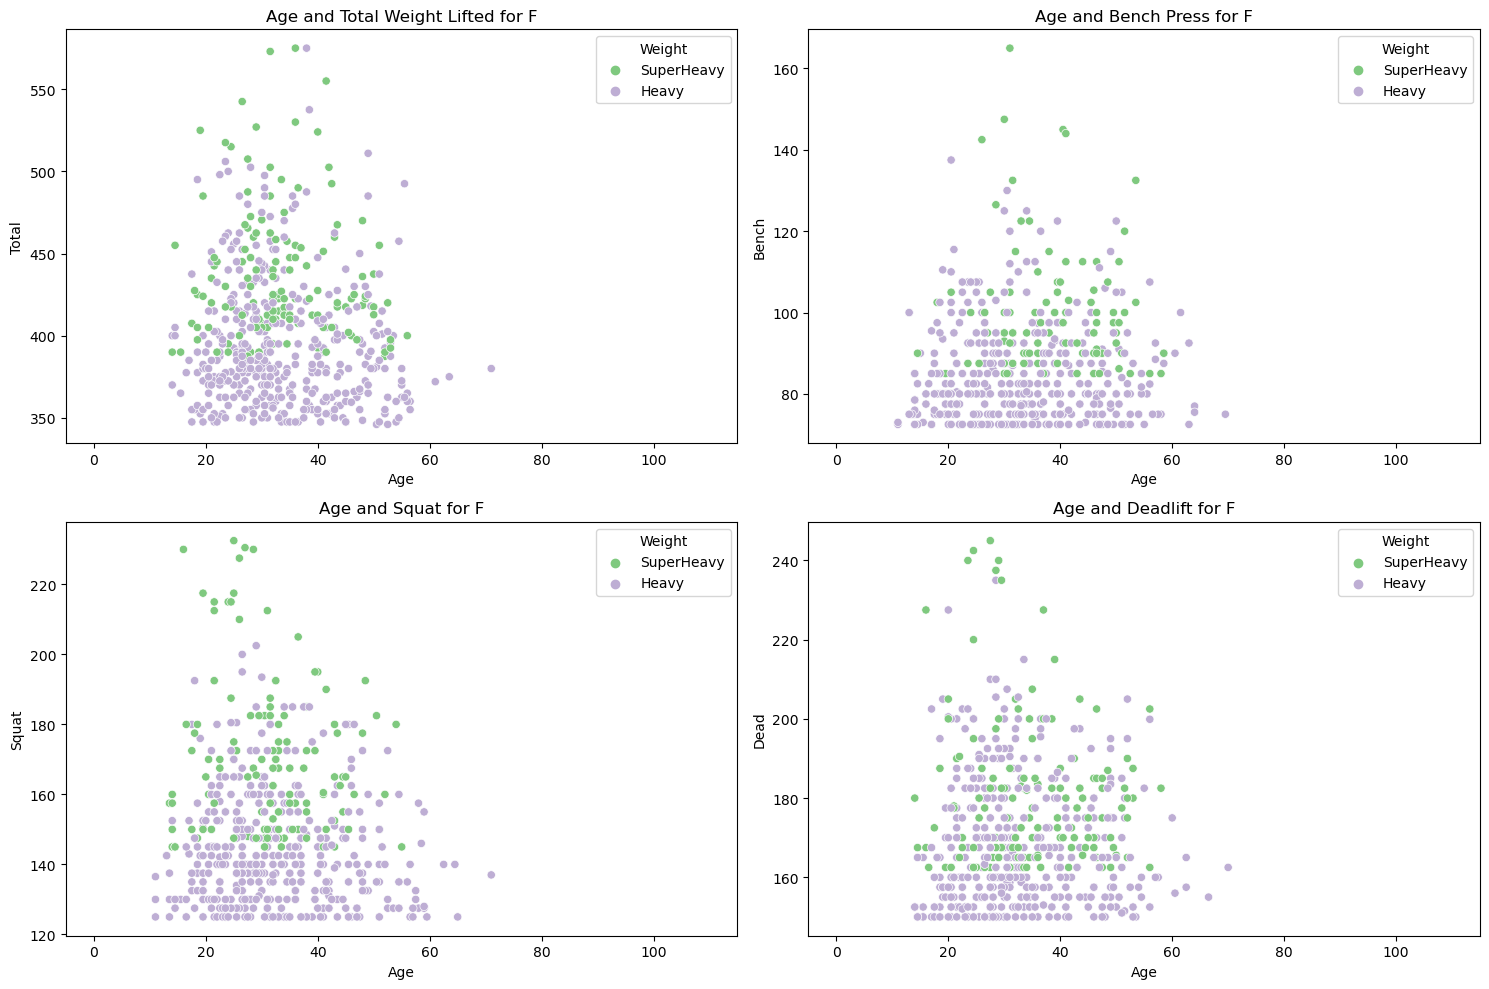

In [22]:
quadrant_hue(sample(total,500),sample(bench,500),
         sample(squat,500),sample(dead,500),'F','Weight','Heavier')

# 1) Gaussian Distribution

Explore normality between Age Groups and Peak Strength levels across Total, Bench, Dead, and Squat

In [23]:
def max_strength(total, sex):
    summary = pd.DataFrame()
    col = total.columns[3]
    cutoff = total[total['Sex'] == sex].groupby('AgeGroup')[col].quantile(.9).reset_index().copy()
    return cutoff

def shapiro_wilk(total, sex, alpha):
    a = max_strength(total, sex)
    col = total.columns[3]
    stat, p = stats.shapiro(a[col])
    if p > alpha:
        return 'The data appears to be normally distributed (fail to reject H0)'
    else:
        return 'The data does not appear to be normally distributed (reject H0)'
        
def bar_quadrant(total, bench, squat, dead, sex):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    axs[0, 0].set_title('Top Total per Age Group for ' + sex)
    axs[0, 1].set_title('Top Bench Press per Age Group for ' + sex)
    axs[1, 0].set_title('Top Squat per Age Group for ' + sex)
    axs[1, 1].set_title('Top Deadlift per Age Group for ' + sex)

    sns.barplot(max_strength(total, sex), x='AgeGroup', y='Total', color='steelblue', ax=axs[0, 0])
    sns.barplot(max_strength(bench, sex), x='AgeGroup', y='Bench', color='steelblue', ax=axs[0, 1])
    sns.barplot(max_strength(squat, sex), x='AgeGroup', y='Squat', color='steelblue', ax=axs[1, 0])
    sns.barplot(max_strength(dead, sex), x='AgeGroup', y='Dead', color='steelblue', ax=axs[1, 1])
    
    total_conclusion = shapiro_wilk(total, sex, alpha=0.05)
    bench_conclusion = shapiro_wilk(bench, sex, alpha=0.05)
    squat_conclusion = shapiro_wilk(squat, sex, alpha=0.05)
    dead_conclusion = shapiro_wilk(dead, sex, alpha=0.05)
    for ax in axs.flat:
        for bar in ax.patches:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                    round(bar.get_height(), 2), ha='center', va='bottom')
        
    axs[0, 0].text(0.5, -0.2, total_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[0, 0].transAxes, fontsize=10, color='red')
    axs[0, 1].text(0.5, -0.2, bench_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[0, 1].transAxes, fontsize=10, color='red')
    axs[1, 0].text(0.5, -0.2, squat_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[1, 0].transAxes, fontsize=10, color='red')
    axs[1, 1].text(0.5, -0.2, dead_conclusion, horizontalalignment='center', verticalalignment='center', 
                   transform=axs[1, 1].transAxes, fontsize=10, color='red')

    plt.tight_layout()


Null Hypothesis: The distribution of Top Strength per Age Group is normally distributed.

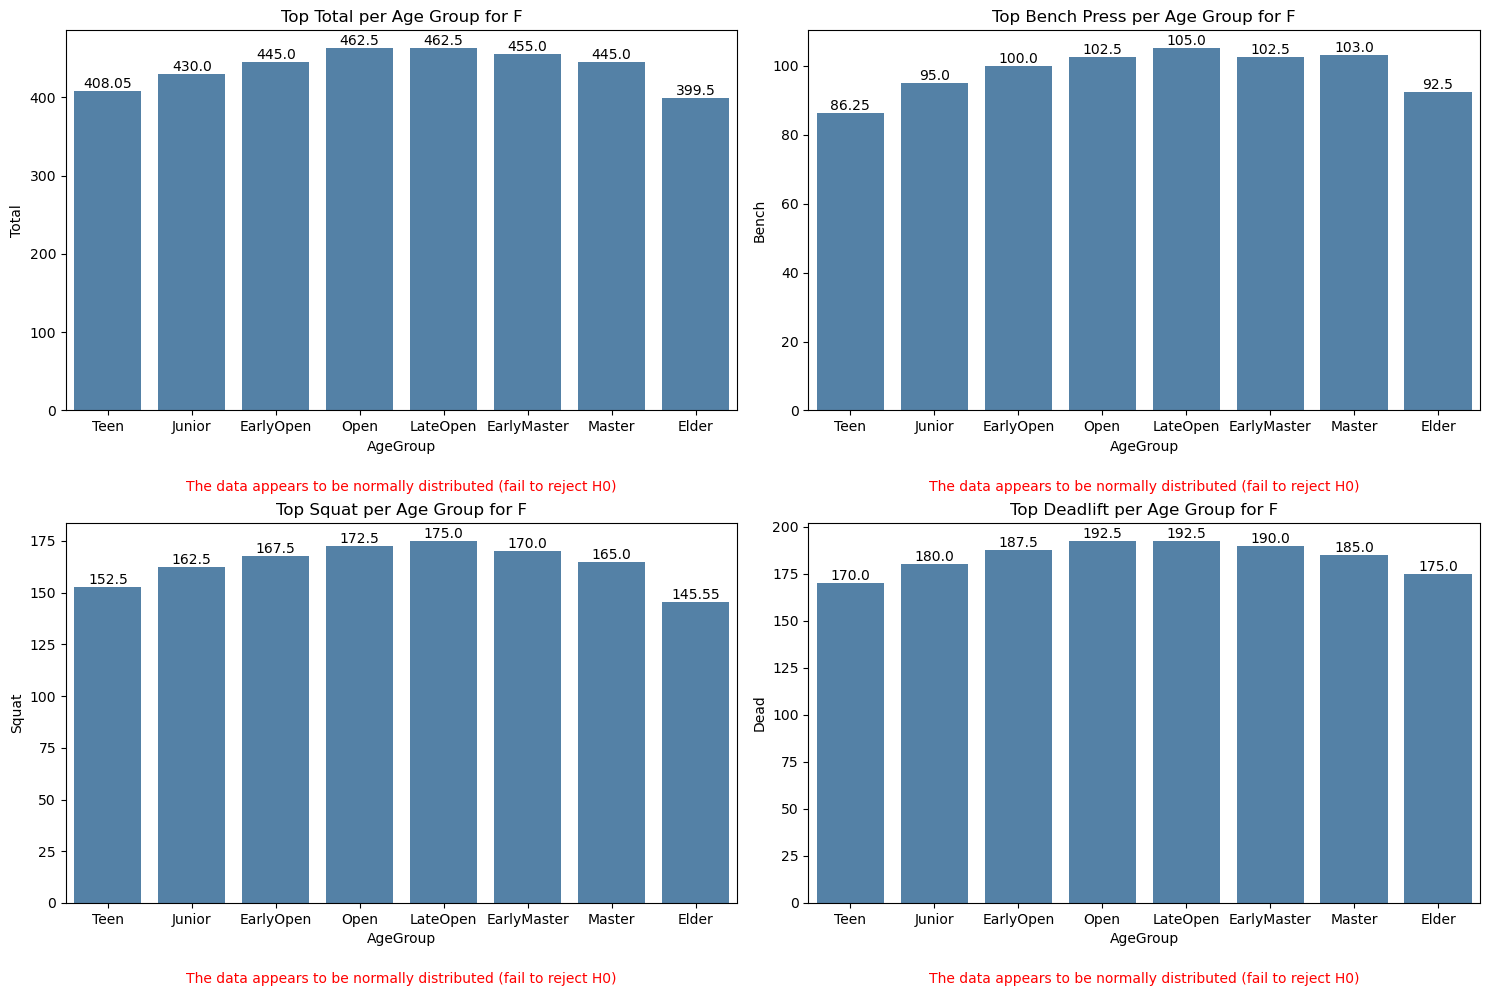

In [24]:
bar_quadrant(total,bench,squat,dead,'F')

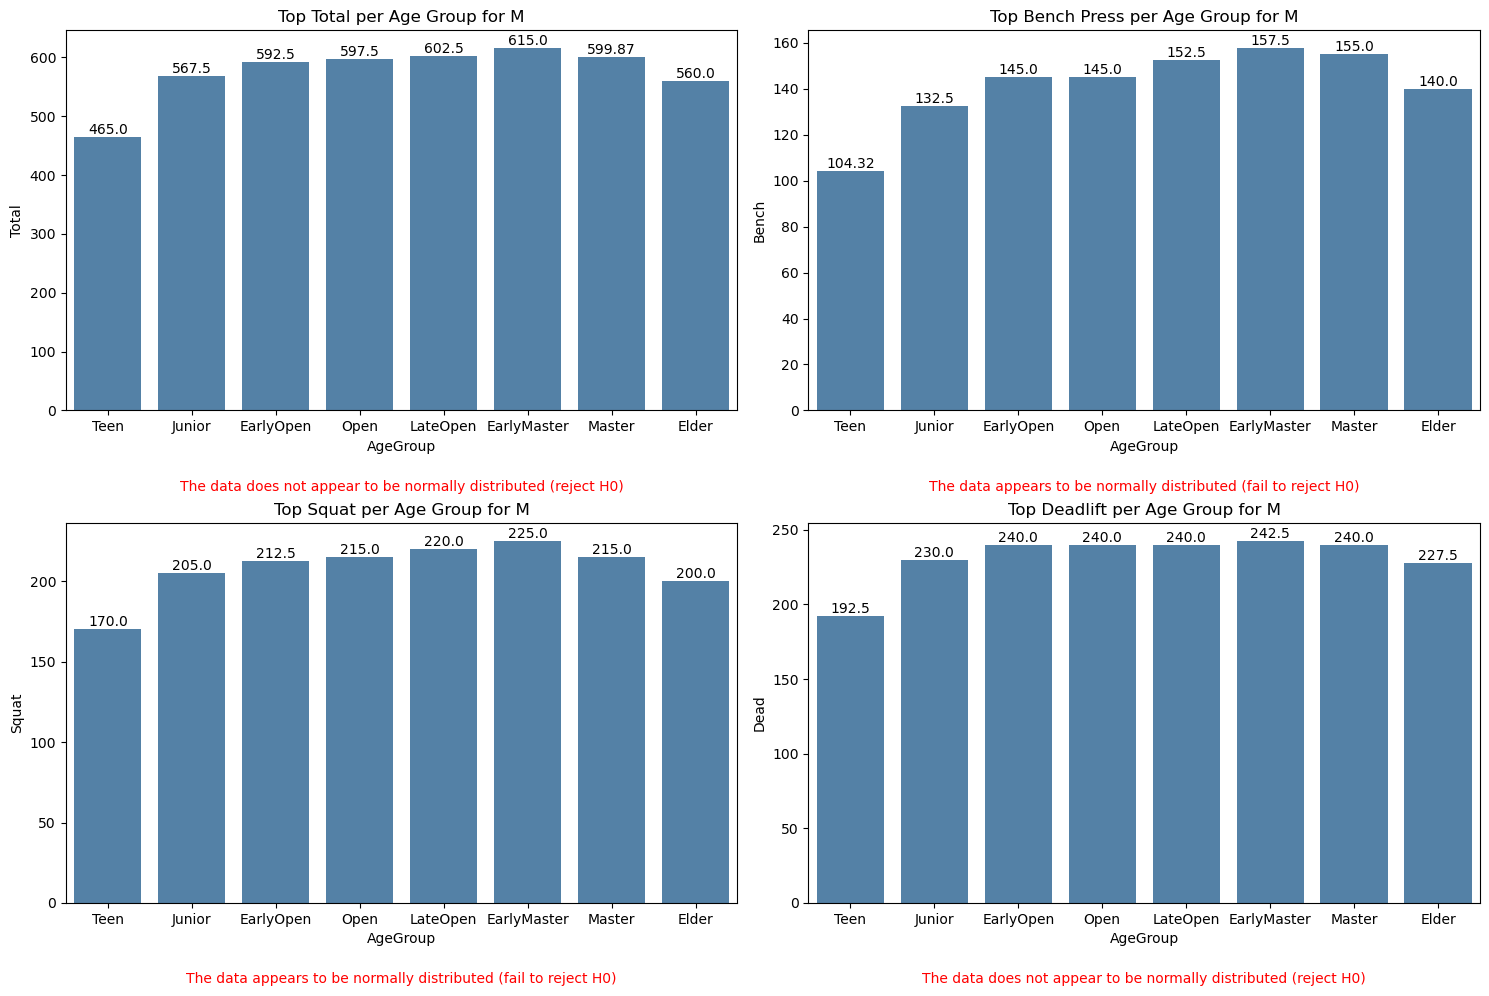

In [25]:
bar_quadrant(total,bench,squat,dead,'M')

# 2) Descriptive Statistical Testing

Top 10% of Total, Bench, Dead, and Squat for each Weight Group
- Statistical testing for difference in means in the top lifters per each weight class

In [26]:
def max_strength_df(total, sex):
    summary = pd.DataFrame()
    col = total.columns[3]
    cutoff = total[total['Sex'] == sex].groupby('Weight')[col].quantile(.9).reset_index().copy()
    for x in range(len(cutoff)):
        weight = cutoff.iloc[x,0]
        strength = cutoff.iloc[x,1]
        df = total[total['Sex'] == sex][(total[total['Sex'] == sex]['Weight']==weight)&(total[total['Sex'] == sex][col]>=strength)].copy()
        summary = pd.concat([summary, df], axis = 0, ignore_index = True)
    return summary

def mean_age_difference_z_test(total, sex, alpha):
    results = {}
    df = max_strength_df(total, sex)
    weight_groups = df['Weight'].unique()
    
    for i in range(len(weight_groups)):
        for j in range(i + 1, len(weight_groups)):
            group1 = weight_groups[i]
            group2 = weight_groups[j]
            sample1 = df[(df['Weight'] == group1) & (df['Sex'] == sex)]['Age']
            sample2 = df[(df['Weight'] == group2) & (df['Sex'] == sex)]['Age']
            z_stat, p_value = ztest(sample1, sample2)

            p_value_formatted = '{:.5f}'.format(p_value) 
            
            if p_value < alpha:
                decision = 'Reject H0: There is a significant difference'
            else:
                decision = 'Fail to reject H0: There is no significant difference'
            
            results[f'{group1} vs {group2}'] = {'Z statistic': z_stat,
                                                 'p-value': p_value_formatted,
                                                 'Decision': decision}
    print(df.groupby('Weight')['Age'].describe())
    return results

def mean_weight_age_z_test(total, sex, alpha):
    results = {}
    df = max_strength_df(total, sex)
    df = df[(df['AgeGroup']!='Teen')&(df['AgeGroup']!='Elder')] # low samples
    age_groups = df['AgeGroup'].unique()
    col = df.columns[3]
    top_age = df.groupby('AgeGroup')[col].mean().idxmax()
    age_groups = [x for x in age_groups if (x != top_age)]
    sample1 = df[(df['AgeGroup'] == top_age) & (df['Sex'] == sex)][col]
    for i in range(len(age_groups)):
        group2 = age_groups[i]
        sample2 = df[(df['AgeGroup'] == group2) & (df['Sex'] == sex)][col]
        z_stat, p_value = ztest(sample1, sample2)

        p_value_formatted = '{:.5f}'.format(p_value) 

        if p_value < alpha:
            decision = 'Reject H0: There is a significant difference'
        else:
            decision = 'Fail to reject H0: There is no significant difference'

        results[f'{top_age} vs {group2}'] = {'Z statistic': z_stat,
                                             'p-value': p_value_formatted,
                                             'Decision': decision}
    print(df.groupby('AgeGroup')[col].describe())
    return results

Null hypothesis: The mean weight lifted, in peak lifters, of the strongest Age Group is not different than the other Age Groups

Total Weight Lifted

In [27]:
mean_weight_age_z_test(total, 'F', .05)

              count        mean        std    min     25%    50%      75%  \
AgeGroup                                                                    
Teen            0.0         NaN        NaN    NaN     NaN    NaN      NaN   
Junior        257.0  473.188716  61.040413  355.0  427.50  468.5  513.500   
EarlyOpen    1454.0  459.247827  54.420414  355.0  425.00  462.5  495.000   
Open         1422.0  470.345619  60.412378  355.0  430.50  467.5  507.500   
LateOpen      816.0  466.027390  59.908917  355.0  423.75  467.5  505.000   
EarlyMaster   562.0  471.060445  57.325702  355.0  437.50  470.5  514.875   
Master        129.0  470.697674  54.795943  355.0  427.50  477.5  508.000   
Elder           0.0         NaN        NaN    NaN     NaN    NaN      NaN   

               max  
AgeGroup            
Teen           NaN  
Junior       612.5  
EarlyOpen    647.5  
Open         667.5  
LateOpen     662.5  
EarlyMaster  667.5  
Master       575.0  
Elder          NaN  


{'Junior vs EarlyOpen': {'Z statistic': 3.7146303263070553,
  'p-value': '0.00020',
  'Decision': 'Reject H0: There is a significant difference'},
 'Junior vs LateOpen': {'Z statistic': 1.6635796000232221,
  'p-value': '0.09620',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Junior vs Open': {'Z statistic': 0.6932104332722793,
  'p-value': '0.48818',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Junior vs EarlyMaster': {'Z statistic': 0.4830055663786505,
  'p-value': '0.62909',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Junior vs Master': {'Z statistic': 0.39107366367781,
  'p-value': '0.69574',
  'Decision': 'Fail to reject H0: There is no significant difference'}}

In [28]:
mean_weight_age_z_test(total, 'M', .05)

              count        mean        std    min    25%    50%    75%    max
AgeGroup                                                                     
Teen            0.0         NaN        NaN    NaN    NaN    NaN    NaN    NaN
Junior       3270.0  544.106557  64.407509  425.0  530.0  540.0  592.5  667.5
EarlyOpen    5207.0  564.628771  57.339214  425.0  535.0  542.5  597.5  667.5
Open         2710.0  573.251819  53.551230  425.0  537.5  590.0  597.5  667.5
LateOpen     1383.0  585.614093  56.747578  425.0  540.0  592.5  600.0  667.5
EarlyMaster  1491.0  591.915714  56.308483  425.0  540.0  595.0  652.5  667.5
Master        685.0  581.844321  60.948610  425.0  537.5  590.0  600.0  667.5
Elder           0.0         NaN        NaN    NaN    NaN    NaN    NaN    NaN


{'EarlyMaster vs LateOpen': {'Z statistic': 2.986449458147651,
  'p-value': '0.00282',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Open': {'Z statistic': 10.611817901951472,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 3.7744356007266333,
  'p-value': '0.00016',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 16.266407022527567,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 24.682171790924574,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Squat

In [29]:
mean_weight_age_z_test(squat, 'F', .05)

              count        mean        std    min    25%    50%      75%  \
AgeGroup                                                                   
Teen            0.0         NaN        NaN    NaN    NaN    NaN      NaN   
Junior        430.0  174.752326  26.126859  127.5  155.5  172.5  187.500   
EarlyOpen    1733.0  170.149671  23.520152  127.5  155.0  172.5  182.500   
Open         1562.0  173.855064  25.386061  127.5  157.5  172.5  187.500   
LateOpen      889.0  172.535433  24.173468  127.5  155.0  172.5  187.500   
EarlyMaster   619.0  173.721648  22.410669  127.5  160.0  175.0  187.500   
Master        128.0  170.113281  23.374579  127.5  152.5  172.5  185.125   
Elder           0.0         NaN        NaN    NaN    NaN    NaN      NaN   

               max  
AgeGroup            
Teen           NaN  
Junior       245.0  
EarlyOpen    245.0  
Open         245.0  
LateOpen     245.0  
EarlyMaster  242.5  
Master       213.0  
Elder          NaN  


{'Junior vs Open': {'Z statistic': 0.6449104692053454,
  'p-value': '0.51899',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Junior vs EarlyOpen': {'Z statistic': 3.5507164157083606,
  'p-value': '0.00038',
  'Decision': 'Reject H0: There is a significant difference'},
 'Junior vs LateOpen': {'Z statistic': 1.5201597086869114,
  'p-value': '0.12847',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Junior vs EarlyMaster': {'Z statistic': 0.6839884181406231,
  'p-value': '0.49398',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Junior vs Master': {'Z statistic': 1.8050774285911844,
  'p-value': '0.07106',
  'Decision': 'Fail to reject H0: There is no significant difference'}}

In [30]:
mean_weight_age_z_test(squat, 'M', .05)

              count        mean        std    min    25%    50%    75%    max
AgeGroup                                                                     
Teen            0.0         NaN        NaN    NaN    NaN    NaN    NaN    NaN
Junior       3774.0  197.299396  24.909128  147.5  190.0  192.5  212.5  245.0
EarlyOpen    5877.0  203.559578  22.758240  147.5  190.0  210.0  215.0  245.0
Open         3293.0  207.561266  20.731752  147.5  192.5  210.0  215.0  245.0
LateOpen     1695.0  210.739510  22.025013  147.5  192.5  210.0  215.0  245.0
EarlyMaster  1618.0  213.509061  23.266570  147.5  210.0  212.5  240.0  245.0
Master        788.0  211.890558  23.301091  147.5  192.5  210.0  240.0  245.0
Elder           0.0         NaN        NaN    NaN    NaN    NaN    NaN    NaN


{'EarlyMaster vs LateOpen': {'Z statistic': 3.519644937377649,
  'p-value': '0.00043',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Open': {'Z statistic': 9.07006971751053,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 1.6005693324454662,
  'p-value': '0.10947',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 22.33068743314687,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 15.496606730245064,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Bench

In [31]:
mean_weight_age_z_test(bench, 'F', .05)

              count        mean        std   min     25%     50%    75%    max
AgeGroup                                                                      
Teen            0.0         NaN        NaN   NaN     NaN     NaN    NaN    NaN
Junior        429.0  107.189277  16.479035  80.0   97.50  105.00  112.5  167.5
EarlyOpen    1527.0  105.223700  14.196780  80.0   97.25  105.00  112.5  168.0
Open         1402.0  106.525578  15.120192  80.0   97.50  105.00  115.0  165.0
LateOpen     1051.0  107.886651  17.259581  80.0   97.50  105.00  120.0  167.5
EarlyMaster   835.0  108.861749  15.373130  80.0   98.00  107.50  120.0  152.5
Master        374.0  113.573904  15.437084  80.0  102.50  112.75  125.0  145.0
Elder           0.0         NaN        NaN   NaN     NaN     NaN    NaN    NaN


{'Master vs EarlyOpen': {'Z statistic': 10.016809472507349,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs LateOpen': {'Z statistic': 5.622083700311653,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs Open': {'Z statistic': 7.974284502748755,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs EarlyMaster': {'Z statistic': 4.919992104093073,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Master vs Junior': {'Z statistic': 5.639757545866881,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [32]:
mean_weight_age_z_test(bench, 'M', .05)

              count        mean        std   min    25%     50%    75%    max
AgeGroup                                                                     
Teen            0.0         NaN        NaN   NaN    NaN     NaN    NaN    NaN
Junior       4263.0  127.520117  19.511189  97.5  125.0  127.50  142.5  170.0
EarlyOpen    7402.0  135.463952  18.402374  97.5  125.0  142.50  145.0  170.0
Open         4398.0  139.041260  18.048445  97.5  125.0  142.50  145.0  170.0
LateOpen     2554.0  142.873410  18.705118  97.5  127.5  142.69  165.0  170.0
EarlyMaster  2977.0  144.914508  19.366531  97.5  127.5  145.00  165.0  170.0
Master       2004.0  144.629805  20.605508  97.5  127.5  145.00  165.0  170.0
Elder           0.0         NaN        NaN   NaN    NaN     NaN    NaN    NaN


{'EarlyMaster vs Open': {'Z statistic': 13.310512635580022,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs LateOpen': {'Z statistic': 3.969614031838985,
  'p-value': '0.00007',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 23.306355963582146,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 0.4957704162475044,
  'p-value': '0.62006',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 37.43917817009144,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Dead

In [33]:
mean_weight_age_z_test(dead, 'F', .05)

              count        mean        std    min     25%     50%      75%  \
AgeGroup                                                                     
Teen            0.0         NaN        NaN    NaN     NaN     NaN      NaN   
Junior        260.0  192.641308  20.750973  152.5  180.00  195.00  207.125   
EarlyOpen    1706.0  191.256940  20.380637  152.5  180.00  193.00  205.000   
Open         1702.0  195.230729  21.631447  152.5  182.50  195.00  207.500   
LateOpen      972.0  196.099568  22.683374  152.5  182.25  197.50  210.000   
EarlyMaster   890.0  195.851393  22.272151  152.5  182.50  195.27  212.500   
Master        205.0  195.205463  21.570030  152.5  180.00  197.50  207.500   
Elder           0.0         NaN        NaN    NaN     NaN     NaN      NaN   

               max  
AgeGroup            
Teen           NaN  
Junior       240.0  
EarlyOpen    260.5  
Open         260.5  
LateOpen     257.5  
EarlyMaster  242.5  
Master       255.0  
Elder          NaN  


{'LateOpen vs EarlyOpen': {'Z statistic': 5.672053482652782,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs EarlyMaster': {'Z statistic': 0.23787532804874556,
  'p-value': '0.81198',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'LateOpen vs Open': {'Z statistic': 0.9814397878127659,
  'p-value': '0.32638',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'LateOpen vs Junior': {'Z statistic': 2.222052361255807,
  'p-value': '0.02628',
  'Decision': 'Reject H0: There is a significant difference'},
 'LateOpen vs Master': {'Z statistic': 0.5171812722191401,
  'p-value': '0.60503',
  'Decision': 'Fail to reject H0: There is no significant difference'}}

In [34]:
mean_weight_age_z_test(dead, 'M', .05)

              count        mean        std    min    25%    50%    75%     max
AgeGroup                                                                      
Teen            0.0         NaN        NaN    NaN    NaN    NaN    NaN     NaN
Junior       4172.0  224.024238  21.758264  180.0  220.0  225.0  240.0  261.00
EarlyOpen    6661.0  230.365526  18.248661  180.0  220.0  225.0  240.0  260.82
Open         3677.0  233.489013  17.120885  180.0  222.5  237.5  242.5  261.00
LateOpen     2026.0  236.029566  17.228726  180.0  225.0  240.0  242.5  261.00
EarlyMaster  2141.0  238.461976  18.246931  180.0  225.0  240.0  255.0  262.00
Master       1011.0  235.680396  20.551277  180.0  222.5  240.0  255.0  262.40
Elder           0.0         NaN        NaN    NaN    NaN    NaN    NaN     NaN


{'EarlyMaster vs LateOpen': {'Z statistic': 4.419063333526336,
  'p-value': '0.00001',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs EarlyOpen': {'Z statistic': 17.85915833125957,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Open': {'Z statistic': 10.427118172100126,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Junior': {'Z statistic': 26.318691113472802,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'EarlyMaster vs Master': {'Z statistic': 3.8331705295683856,
  'p-value': '0.00013',
  'Decision': 'Reject H0: There is a significant difference'}}

Null Hypothesis: The mean Age of the top lifters in all Weight Groups of the same Sex are not different.

Total Weight Lifted

In [35]:
mean_age_difference_z_test(total,'M',.05)

             count       mean       std   min   25%   50%     75%   max
Weight                                                                 
Heavy       5650.0  27.318142  9.140622  14.5  21.0  24.5  30.500  66.5
Light       1352.0  23.543639  9.665632  12.5  17.5  20.5  24.625  73.5
Middle      5744.0  25.194203  8.445904  14.0  19.5  22.5  27.500  70.0
SuperHeavy  2264.0  29.953622  9.788644  14.5  22.0  27.5  36.000  62.0


{'Heavy vs Light': {'Z statistic': 13.486168232553492,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 12.885109186480495,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -11.355759373618435,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -6.282484153932565,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -19.141836027165475,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -21.681225921103625,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [36]:
mean_age_difference_z_test(total,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       2095.0  28.148687  6.857881  16.5  23.0  26.5  31.5  56.5
Light        814.0  28.106880  6.605954  17.5  23.0  26.5  31.5  52.0
Middle      1089.0  27.131313  5.911357  16.5  22.5  26.0  30.0  51.5
SuperHeavy   647.0  29.243431  7.748455  15.0  24.0  28.0  33.5  53.0


{'Heavy vs Light': {'Z statistic': 0.14911585229211116,
  'p-value': '0.88146',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Heavy vs Middle': {'Z statistic': 4.157976927579577,
  'p-value': '0.00003',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -3.4388672314763893,
  'p-value': '0.00058',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 3.3862468680903426,
  'p-value': '0.00071',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -3.0246106317679216,
  'p-value': '0.00249',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -6.393544178342427,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Squat

In [37]:
mean_age_difference_z_test(squat,'M',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       7816.0  27.103506  9.272782  14.5  20.5  24.5  30.5  70.5
Light       1419.0  23.577167  9.193685  12.5  18.0  20.5  25.0  73.5
Middle      5524.0  25.173787  8.531790  14.5  19.5  22.5  27.5  72.5
SuperHeavy  2627.0  29.800533  9.747517  15.0  22.0  27.5  36.0  62.0


{'Heavy vs Light': {'Z statistic': 13.196119579307608,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 12.234302070420323,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -12.729874118825874,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -6.18686896645781,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -19.76574680776262,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -21.83286024024732,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [38]:
mean_age_difference_z_test(squat,'F',.05)

             count       mean       std   min   25%   50%     75%   max
Weight                                                                 
Heavy       2420.0  27.716116  6.793900  14.5  22.5  26.5  31.500  56.5
Light        911.0  27.575741  6.764953  16.0  22.5  26.0  31.000  52.0
Middle      1352.0  26.978180  6.237859  15.5  22.5  25.5  30.125  50.5
SuperHeavy   683.0  28.138360  7.702560  14.5  22.5  27.0  31.500  52.5


{'Heavy vs Light': {'Z statistic': 0.5321753543016678,
  'p-value': '0.59460',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Heavy vs Middle': {'Z statistic': 3.2929313249794476,
  'p-value': '0.00099',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -1.3914052340653449,
  'p-value': '0.16410',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs Middle': {'Z statistic': 2.1596272634335865,
  'p-value': '0.03080',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -1.5478096962548193,
  'p-value': '0.12167',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -3.6533892124884764,
  'p-value': '0.00026',
  'Decision': 'Reject H0: There is a significant difference'}}

Bench

In [39]:
mean_age_difference_z_test(bench,'M',.05)

             count       mean        std   min   25%   50%   75%   max
Weight                                                                
Heavy       8486.0  29.411030  10.954456  14.5  21.5  25.5  34.0  81.0
Light       2618.0  26.017571  12.556067  13.0  18.0  21.5  28.0  79.5
Middle      8868.0  27.850925  11.127279  14.0  20.5  23.5  31.0  81.0
SuperHeavy  4838.0  33.888797  11.638104  15.0  24.0  31.5  42.5  76.5


{'Heavy vs Light': {'Z statistic': 13.37066155330112,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 9.303088720730905,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -22.17787287345906,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -7.187059881562665,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -27.106328427937466,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -29.86781485435264,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [40]:
mean_age_difference_z_test(bench,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       2594.0  29.649383  8.925482  14.0  23.0  27.5  34.0  67.5
Light       1044.0  28.722701  7.877384  14.0  22.5  27.0  33.0  61.0
Middle      1372.0  28.242347  7.509254  15.0  22.5  27.0  32.5  59.0
SuperHeavy   664.0  32.536898  9.111497  15.0  26.0  31.0  39.0  54.5


{'Heavy vs Light': {'Z statistic': 2.9270423793586313,
  'p-value': '0.00342',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 4.980713033734581,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -7.406817898966258,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 1.5248181416871576,
  'p-value': '0.12730',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -9.17109128205137,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -11.261643443872941,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Deadlift

In [41]:
mean_age_difference_z_test(dead,'M',.05)

             count       mean        std   min   25%   50%   75%   max
Weight                                                                
Heavy       7486.0  27.710994   9.641264  14.5  21.0  25.0  31.5  73.0
Light       1615.0  24.726625  11.263119  12.5  18.0  20.5  26.5  89.0
Middle      7808.0  25.739562   8.977843  14.0  20.0  23.0  28.5  76.5
SuperHeavy  3295.0  30.877238  10.400351  14.5  22.5  28.5  37.5  64.0


{'Heavy vs Light': {'Z statistic': 10.933818345278649,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs Middle': {'Z statistic': 13.092945460873057,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -15.329774747200235,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': -3.9382912027881503,
  'p-value': '0.00008',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -18.938364631356606,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -26.247239818471087,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [42]:
mean_age_difference_z_test(dead,'F',.05)

             count       mean       std   min   25%   50%   75%   max
Weight                                                               
Heavy       2386.0  28.860645  7.350392  16.5  23.5  27.5  32.5  56.5
Light       1071.0  28.553221  7.276577  17.0  23.0  27.0  33.0  60.0
Middle      1535.0  27.792508  6.490047  16.0  23.0  26.5  30.5  55.0
SuperHeavy   761.0  30.921813  7.921332  15.0  25.0  29.5  36.5  59.0


{'Heavy vs Light': {'Z statistic': 1.1406589506461666,
  'p-value': '0.25401',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'Heavy vs Middle': {'Z statistic': 4.646203541581045,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Heavy vs SuperHeavy': {'Z statistic': -6.608068638402767,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs Middle': {'Z statistic': 2.7998179260939478,
  'p-value': '0.00511',
  'Decision': 'Reject H0: There is a significant difference'},
 'Light vs SuperHeavy': {'Z statistic': -6.616195961012834,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'Middle vs SuperHeavy': {'Z statistic': -10.088181692873905,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

Null Hypothesis: The mean Age of the top lifters in each Weight Group are the same across Sex.

In [43]:
def mean_age_difference_z_test_2(total, alpha):
    results = {}
    df1 = max_strength_df(total, 'M')
    df2 = max_strength_df(total,'F')
    
    weight_groups = df['Weight'].unique()
    
    for i in range(len(weight_groups)):
        weight = weight_groups[i]
        sample1 = df1[df1['Weight']==weight]['Age'].copy()
        sample2 = df2[df2['Weight']==weight]['Age'].copy()
        z_stat, p_value = ztest(sample1, sample2)

        p_value_formatted = '{:.5f}'.format(p_value) 

        if p_value < alpha:
            decision = 'Reject H0: There is a significant difference'
        else:
            decision = 'Fail to reject H0: There is no significant difference'

        results[f'F v M in {weight}'] = {'Z statistic': z_stat,
                                             'p-value': p_value_formatted,
                                             'Decision': decision}
    dfs = pd.concat([df2.groupby('Weight')['Age'].mean(),
           df1.groupby('Weight')['Age'].mean()], axis = 1)
    dfs['Delta'] = dfs.iloc[:,0]-dfs.iloc[:,1]
    dfs.columns = ['F mean age','M mean age', 'Delta']
    print(dfs)
    return results

In [44]:
mean_age_difference_z_test_2(total,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        28.148687   27.318142  0.830546
Light        28.106880   23.543639  4.563241
Middle       27.131313   25.194203  1.937110
SuperHeavy   29.243431   29.953622 -0.710191


{'F v M in Middle': {'Z statistic': -7.239774819787065,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Heavy': {'Z statistic': -3.782775935779546,
  'p-value': '0.00016',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': 1.699490077772988,
  'p-value': '0.08923',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'F v M in Light': {'Z statistic': -11.89941249428618,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [45]:
mean_age_difference_z_test_2(squat,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        27.716116   27.103506  0.612610
Light        27.575741   23.577167  3.998574
Middle       26.978180   25.173787  1.804393
SuperHeavy   28.138360   29.800533 -1.662173


{'F v M in Middle': {'Z statistic': -7.31257841265693,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Heavy': {'Z statistic': -3.00945702293429,
  'p-value': '0.00262',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': 4.133415131448977,
  'p-value': '0.00004',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -11.307901271953991,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [46]:
mean_age_difference_z_test_2(bench,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        29.649383   29.411030  0.238353
Light        28.722701   26.017571  2.705130
Middle       28.242347   27.850925  0.391422
SuperHeavy   32.536898   33.888797 -1.351899


{'F v M in Middle': {'Z statistic': -1.2593290603724334,
  'p-value': '0.20791',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'F v M in Heavy': {'Z statistic': -1.0103947771492556,
  'p-value': '0.31231',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'F v M in SuperHeavy': {'Z statistic': 2.8747141625870922,
  'p-value': '0.00404',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Light': {'Z statistic': -6.471531214768601,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

In [47]:
mean_age_difference_z_test_2(dead,.05)

            F mean age  M mean age     Delta
Weight                                      
Heavy        28.860645   27.710994  1.149652
Light        28.553221   24.726625  3.826596
Middle       27.792508   25.739562  2.052946
SuperHeavy   30.921813   30.877238  0.044575


{'F v M in Middle': {'Z statistic': -8.531315623081248,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in Heavy': {'Z statistic': -5.350027253790075,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'},
 'F v M in SuperHeavy': {'Z statistic': -0.11102478367346885,
  'p-value': '0.91160',
  'Decision': 'Fail to reject H0: There is no significant difference'},
 'F v M in Light': {'Z statistic': -9.839570355950581,
  'p-value': '0.00000',
  'Decision': 'Reject H0: There is a significant difference'}}

# 3) Peak Age Linear Regression Testing

Exploring the relationship leading up to and after the Peak Age per Weight Group for top strength levels

In [48]:
def pre_peak_lin(total,sex):
    aa = max_strength_df(total,sex)
    a = aa.groupby('Weight')['Age'].describe()[['mean','std']]
    col = aa.columns[3]

    a['high'] = a['mean']-a['std']
    results = {}
    for x in range(len(a)):
        weight = a.index[x]
        high = a.iloc[x,2]
        high_df = aa[(aa['Weight']== a.index[x])&(aa['Age']<=high)].copy()
        high_r = stats.linregress(high_df['Age'],high_df[col])
        results[f'{col} and Age Pre-Peak Age for {weight} {sex}'] = {'Peak-Age':round(high,2),
                                                                     'Slope':round(stats.linregress(high_df['Age'],high_df[col])[0],2),
                                                                'p-value':'{:.5f}'.format(stats.linregress(high_df['Age'],high_df[col])[3]),
                                                                'R':round(stats.linregress(high_df['Age'],high_df[col])[2],2)}
    return results

Null Hypothesis: The slope of the linear relationship between Age and Strength is 0 for top lifters leading up to Peak Age

Sex: M

In [49]:
pre_peak_lin(total,'M')

{'Total and Age Pre-Peak Age for Heavy M': {'Peak-Age': 18.18,
  'Slope': -0.25,
  'p-value': '0.39917',
  'R': -0.04},
 'Total and Age Pre-Peak Age for Light M': {'Peak-Age': 13.88,
  'Slope': 4.55,
  'p-value': '0.12961',
  'R': 0.87},
 'Total and Age Pre-Peak Age for Middle M': {'Peak-Age': 16.75,
  'Slope': 0.46,
  'p-value': '0.38908',
  'R': 0.06},
 'Total and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 20.16,
  'Slope': -0.23,
  'p-value': '0.34946',
  'R': -0.05}}

In [50]:
pre_peak_lin(squat,'M')

{'Squat and Age Pre-Peak Age for Heavy M': {'Peak-Age': 17.83,
  'Slope': -0.07,
  'p-value': '0.59911',
  'R': -0.02},
 'Squat and Age Pre-Peak Age for Light M': {'Peak-Age': 14.38,
  'Slope': -2.15,
  'p-value': '0.00002',
  'R': -0.93},
 'Squat and Age Pre-Peak Age for Middle M': {'Peak-Age': 16.64,
  'Slope': 0.32,
  'p-value': '0.03245',
  'R': 0.15},
 'Squat and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 20.05,
  'Slope': 0.01,
  'p-value': '0.94131',
  'R': 0.0}}

In [51]:
pre_peak_lin(bench,'M')

/Users/tom/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/tom/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/tom/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


{'Bench and Age Pre-Peak Age for Heavy M': {'Peak-Age': 18.46,
  'Slope': 0.18,
  'p-value': '0.02002',
  'R': 0.11},
 'Bench and Age Pre-Peak Age for Light M': {'Peak-Age': 13.46,
  'Slope': nan,
  'p-value': 'nan',
  'R': 0.0},
 'Bench and Age Pre-Peak Age for Middle M': {'Peak-Age': 16.72,
  'Slope': 0.17,
  'p-value': '0.09760',
  'R': 0.1},
 'Bench and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 22.25,
  'Slope': 0.08,
  'p-value': '0.10408',
  'R': 0.06}}

In [52]:
pre_peak_lin(dead,'M')

{'Dead and Age Pre-Peak Age for Heavy M': {'Peak-Age': 18.07,
  'Slope': 0.06,
  'p-value': '0.49986',
  'R': 0.03},
 'Dead and Age Pre-Peak Age for Light M': {'Peak-Age': 13.46,
  'Slope': -0.83,
  'p-value': '0.78878',
  'R': -0.17},
 'Dead and Age Pre-Peak Age for Middle M': {'Peak-Age': 16.76,
  'Slope': 0.02,
  'p-value': '0.92630',
  'R': 0.01},
 'Dead and Age Pre-Peak Age for SuperHeavy M': {'Peak-Age': 20.48,
  'Slope': 0.01,
  'p-value': '0.94769',
  'R': 0.0}}

Sex: F

In [53]:
pre_peak_lin(total,'F')

{'Total and Age Pre-Peak Age for Heavy F': {'Peak-Age': 21.29,
  'Slope': 7.74,
  'p-value': '0.00008',
  'R': 0.25},
 'Total and Age Pre-Peak Age for Light F': {'Peak-Age': 21.5,
  'Slope': 1.89,
  'p-value': '0.33229',
  'R': 0.09},
 'Total and Age Pre-Peak Age for Middle F': {'Peak-Age': 21.22,
  'Slope': 4.32,
  'p-value': '0.00508',
  'R': 0.25},
 'Total and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 21.49,
  'Slope': -4.13,
  'p-value': '0.04935',
  'R': -0.21}}

In [54]:
pre_peak_lin(squat,'F')

{'Squat and Age Pre-Peak Age for Heavy F': {'Peak-Age': 20.92,
  'Slope': 2.18,
  'p-value': '0.00000',
  'R': 0.26},
 'Squat and Age Pre-Peak Age for Light F': {'Peak-Age': 20.81,
  'Slope': 0.34,
  'p-value': '0.50980',
  'R': 0.07},
 'Squat and Age Pre-Peak Age for Middle F': {'Peak-Age': 20.74,
  'Slope': 2.07,
  'p-value': '0.00000',
  'R': 0.37},
 'Squat and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 20.44,
  'Slope': 0.08,
  'p-value': '0.91977',
  'R': 0.01}}

In [55]:
pre_peak_lin(bench,'F')

{'Bench and Age Pre-Peak Age for Heavy F': {'Peak-Age': 20.72,
  'Slope': 0.63,
  'p-value': '0.08234',
  'R': 0.1},
 'Bench and Age Pre-Peak Age for Light F': {'Peak-Age': 20.85,
  'Slope': 0.08,
  'p-value': '0.81708',
  'R': 0.02},
 'Bench and Age Pre-Peak Age for Middle F': {'Peak-Age': 20.73,
  'Slope': 0.68,
  'p-value': '0.12117',
  'R': 0.12},
 'Bench and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 23.43,
  'Slope': -2.11,
  'p-value': '0.00064',
  'R': -0.34}}

In [56]:
pre_peak_lin(dead,'F')

{'Dead and Age Pre-Peak Age for Heavy F': {'Peak-Age': 21.51,
  'Slope': 0.43,
  'p-value': '0.38011',
  'R': 0.05},
 'Dead and Age Pre-Peak Age for Light F': {'Peak-Age': 21.28,
  'Slope': 2.07,
  'p-value': '0.00282',
  'R': 0.28},
 'Dead and Age Pre-Peak Age for Middle F': {'Peak-Age': 21.3,
  'Slope': 1.85,
  'p-value': '0.00278',
  'R': 0.23},
 'Dead and Age Pre-Peak Age for SuperHeavy F': {'Peak-Age': 23.0,
  'Slope': 1.19,
  'p-value': '0.01172',
  'R': 0.24}}

Null Hypothesis: The slope of the linear relationship between Age and Strength is 0 for top lifters after to Peak Age

In [57]:
def post_peak_lin(total,sex):
    aa = max_strength_df(total,sex)
    a = aa.groupby('Weight')['Age'].describe()[['mean','std']]
    col = aa.columns[3]
    a['low'] = a['mean']+a['std']
    results = {}
    for x in range(len(a)):
        weight = a.index[x]
        low = a.iloc[x,2]
        low_df = aa[(aa['Weight']== a.index[x])&(aa['Age']>=low)].copy()
        low_r = stats.linregress(low_df['Age'],low_df[col])
        results[f'{col} and Age Post-Peak Age for {weight} {sex}'] = {'Peak-Age':round(low,2),
                                                                      'Slope':round(stats.linregress(low_df['Age'],low_df[col])[0],2),
                                                                'p-value':'{:.5f}'.format(stats.linregress(low_df['Age'],low_df[col])[3]),
                                                                'R':round(stats.linregress(low_df['Age'],low_df[col])[2],2)}
    return results

Sex: M

In [58]:
post_peak_lin(total,'M')

{'Total and Age Post-Peak Age for Heavy M': {'Peak-Age': 36.46,
  'Slope': -0.13,
  'p-value': '0.00000',
  'R': -0.21},
 'Total and Age Post-Peak Age for Light M': {'Peak-Age': 33.21,
  'Slope': -0.03,
  'p-value': '0.26151',
  'R': -0.09},
 'Total and Age Post-Peak Age for Middle M': {'Peak-Age': 33.64,
  'Slope': -0.03,
  'p-value': '0.15236',
  'R': -0.05},
 'Total and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 39.74,
  'Slope': -0.04,
  'p-value': '0.43851',
  'R': -0.04}}

In [59]:
post_peak_lin(squat,'M')

{'Squat and Age Post-Peak Age for Heavy M': {'Peak-Age': 36.38,
  'Slope': -0.02,
  'p-value': '0.03558',
  'R': -0.06},
 'Squat and Age Post-Peak Age for Light M': {'Peak-Age': 32.77,
  'Slope': 0.0,
  'p-value': '0.98756',
  'R': 0.0},
 'Squat and Age Post-Peak Age for Middle M': {'Peak-Age': 33.71,
  'Slope': 0.01,
  'p-value': '0.05383',
  'R': 0.08},
 'Squat and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 39.55,
  'Slope': 0.0,
  'p-value': '0.92196',
  'R': 0.0}}

In [60]:
post_peak_lin(bench,'M')

{'Bench and Age Post-Peak Age for Heavy M': {'Peak-Age': 40.37,
  'Slope': -0.0,
  'p-value': '0.52932',
  'R': -0.02},
 'Bench and Age Post-Peak Age for Light M': {'Peak-Age': 38.57,
  'Slope': -0.02,
  'p-value': '0.00225',
  'R': -0.16},
 'Bench and Age Post-Peak Age for Middle M': {'Peak-Age': 38.98,
  'Slope': -0.0,
  'p-value': '0.50594',
  'R': -0.02},
 'Bench and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 45.53,
  'Slope': -0.03,
  'p-value': '0.02215',
  'R': -0.08}}

In [61]:
post_peak_lin(dead,'M')

{'Dead and Age Post-Peak Age for Heavy M': {'Peak-Age': 37.35,
  'Slope': -0.02,
  'p-value': '0.00520',
  'R': -0.08},
 'Dead and Age Post-Peak Age for Light M': {'Peak-Age': 35.99,
  'Slope': 0.0,
  'p-value': '0.70953',
  'R': 0.03},
 'Dead and Age Post-Peak Age for Middle M': {'Peak-Age': 34.72,
  'Slope': 0.0,
  'p-value': '0.82067',
  'R': 0.01},
 'Dead and Age Post-Peak Age for SuperHeavy M': {'Peak-Age': 41.28,
  'Slope': -0.02,
  'p-value': '0.20710',
  'R': -0.05}}

Sex: F

In [62]:
post_peak_lin(total,'F')

{'Total and Age Post-Peak Age for Heavy F': {'Peak-Age': 35.01,
  'Slope': -0.77,
  'p-value': '0.01971',
  'R': -0.14},
 'Total and Age Post-Peak Age for Light F': {'Peak-Age': 34.71,
  'Slope': 0.5,
  'p-value': '0.22984',
  'R': 0.11},
 'Total and Age Post-Peak Age for Middle F': {'Peak-Age': 33.04,
  'Slope': -0.65,
  'p-value': '0.19040',
  'R': -0.11},
 'Total and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 36.99,
  'Slope': 0.45,
  'p-value': '0.20119',
  'R': 0.12}}

In [63]:
post_peak_lin(squat,'F')

{'Squat and Age Post-Peak Age for Heavy F': {'Peak-Age': 34.51,
  'Slope': -0.3,
  'p-value': '0.00500',
  'R': -0.15},
 'Squat and Age Post-Peak Age for Light F': {'Peak-Age': 34.34,
  'Slope': 0.13,
  'p-value': '0.28961',
  'R': 0.1},
 'Squat and Age Post-Peak Age for Middle F': {'Peak-Age': 33.22,
  'Slope': -0.43,
  'p-value': '0.00547',
  'R': -0.19},
 'Squat and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 35.84,
  'Slope': -0.33,
  'p-value': '0.03049',
  'R': -0.2}}

In [64]:
post_peak_lin(bench,'F')

{'Bench and Age Post-Peak Age for Heavy F': {'Peak-Age': 38.57,
  'Slope': 0.13,
  'p-value': '0.19386',
  'R': 0.06},
 'Bench and Age Post-Peak Age for Light F': {'Peak-Age': 36.6,
  'Slope': -0.19,
  'p-value': '0.06105',
  'R': -0.16},
 'Bench and Age Post-Peak Age for Middle F': {'Peak-Age': 35.75,
  'Slope': 0.07,
  'p-value': '0.44298',
  'R': 0.06},
 'Bench and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 41.65,
  'Slope': -0.43,
  'p-value': '0.02211',
  'R': -0.21}}

In [65]:
post_peak_lin(dead,'F')

{'Dead and Age Post-Peak Age for Heavy F': {'Peak-Age': 36.21,
  'Slope': -0.34,
  'p-value': '0.00844',
  'R': -0.14},
 'Dead and Age Post-Peak Age for Light F': {'Peak-Age': 35.83,
  'Slope': -0.01,
  'p-value': '0.91014',
  'R': -0.01},
 'Dead and Age Post-Peak Age for Middle F': {'Peak-Age': 34.28,
  'Slope': -0.27,
  'p-value': '0.03664',
  'R': -0.14},
 'Dead and Age Post-Peak Age for SuperHeavy F': {'Peak-Age': 38.84,
  'Slope': 0.03,
  'p-value': '0.87652',
  'R': 0.01}}

# 4) Peak Age Polynomial Regression Testing

In [66]:
def pord(total, sex, deg):
    col = total.columns[3]
    a = total[total['Sex'] == sex].groupby('Age')[col].mean().reset_index().copy()
    X = a['Age']
    Y = a[col]
    poly_model = odr.polynomial(deg)
    data = odr.Data(X, Y)

    odr_obj = odr.ODR(data, poly_model)
    output = odr_obj.run()

    poly = np.poly1d(output.beta[::-1])
    poly_y = poly(X)
    plt.plot(X, Y, label='Weight Lifted')
    plt.plot(X, poly_y, label='Polynomial ODR')
    plt.xlabel('Age')
    plt.ylabel('Weight Lifted')
    plt.legend()
    print('Peak Mean Weight Lifted is at: '+str(X[poly_y.argmax()])+' years old.')
    degf = len(X)-2
    beta_0 = 0
    stat = (output.beta[0] - beta_0) / output.sd_beta[0]
    p_val = stats.t.sf(np.abs(stat), degf) * 2
    print('Recovered equation: y={:3.2f}x + {:3.2f}, t={:3.2f}, p={:.2e}'.format(output.beta[0], output.beta[1], stat, p_val))
    print('R_Squared: '+str(1 - (np.var((Y - poly_y)) / np.var(Y))))

Total Weight Lifted

Peak Mean Weight Lifted is at: 33.0 years old.
Recovered equation: y=-52.77x + 33.10, t=-0.93, p=3.53e-01
R_Squared: 0.2533426188683251


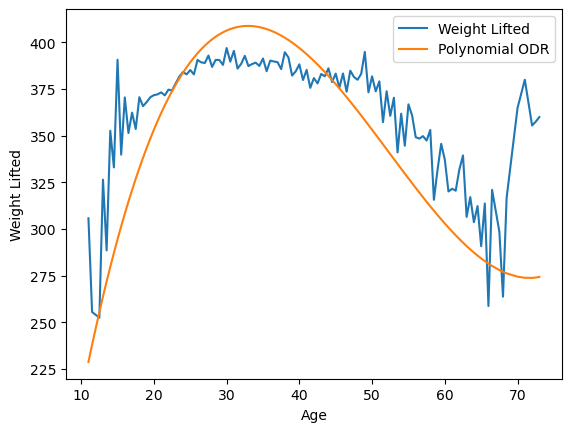

In [67]:
pord(total,'F',3)

Peak Mean Weight Lifted is at: 37.0 years old.
Recovered equation: y=161.52x + 22.56, t=6.92, p=1.26e-10
R_Squared: 0.8779072769499449


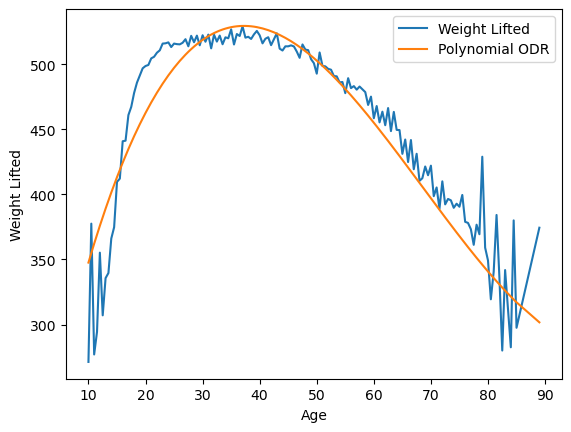

In [68]:
pord(total,'M',3)

Squat

Peak Mean Weight Lifted is at: 32.0 years old.
Recovered equation: y=10.04x + 10.16, t=0.73, p=4.69e-01
R_Squared: 0.6381670827523502


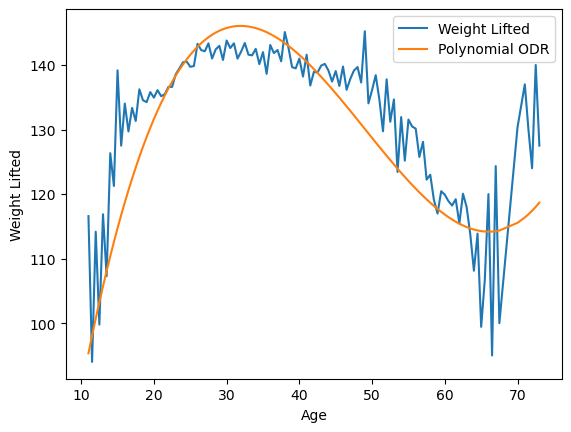

In [69]:
pord(squat,'F',3)

Peak Mean Weight Lifted is at: 38.0 years old.
Recovered equation: y=77.67x + 6.39, t=12.28, p=1.75e-24
R_Squared: 0.8612850548981958


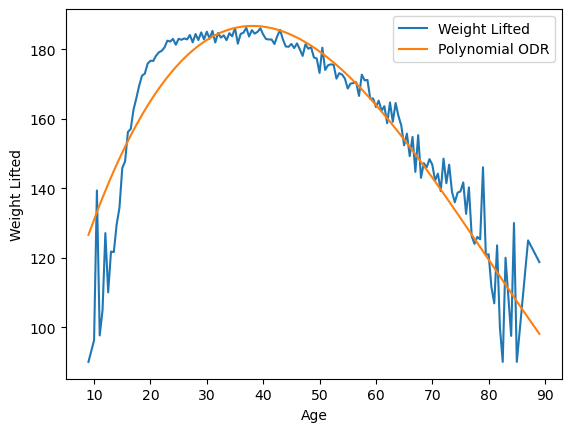

In [70]:
pord(squat,'M',3)

Bench

Peak Mean Weight Lifted is at: 37.5 years old.
Recovered equation: y=47.58x + 2.21, t=13.36, p=7.64e-26
R_Squared: 0.6870393259893683


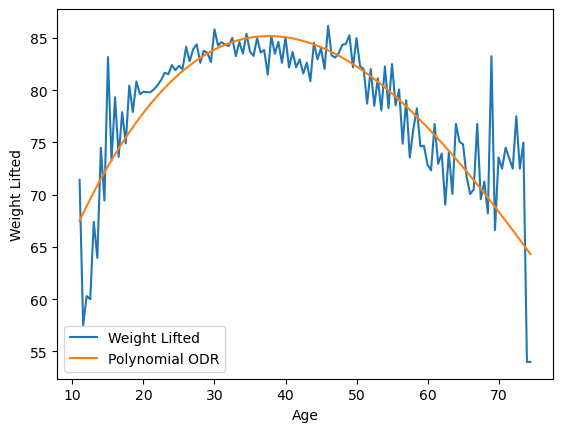

In [71]:
pord(bench,'F',3)

Peak Mean Weight Lifted is at: 39.0 years old.
Recovered equation: y=12.87x + 6.91, t=2.12, p=3.56e-02
R_Squared: 0.9110838070011047


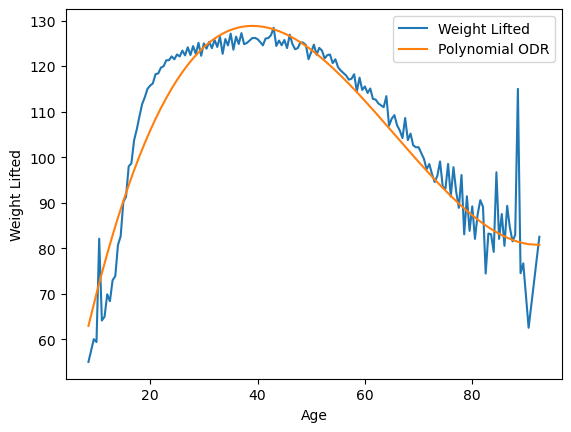

In [72]:
pord(bench,'M',3)

Deadlift

Peak Mean Weight Lifted is at: 37.0 years old.
Recovered equation: y=96.45x + 4.13, t=12.70, p=3.38e-24
R_Squared: 0.6534505234824288


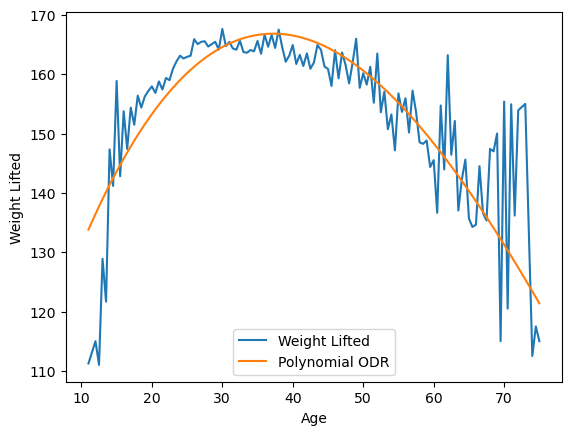

In [73]:
pord(dead,'F',3)

Peak Mean Weight Lifted is at: 37.5 years old.
Recovered equation: y=81.58x + 8.20, t=10.23, p=4.74e-19
R_Squared: 0.8603430773882446


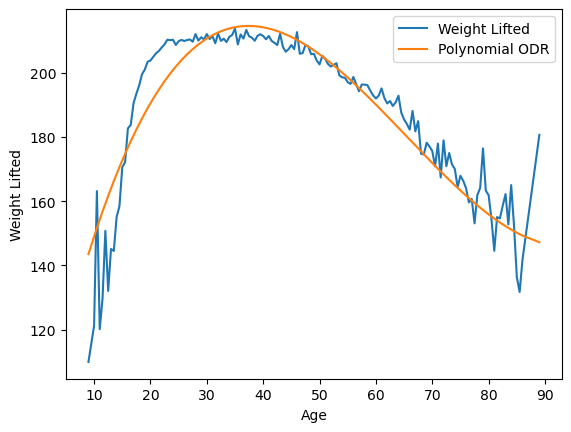

In [74]:
pord(dead,'M',3)

# Export Drug Tested Top Strength Population

Export the dataframe consisting of top 10% strength for each weight group

In [75]:
max_strength_df(total,'M').to_pickle('GP_Total_M.pkl')
max_strength_df(squat,'M').to_pickle('GP_Squat_M.pkl')
max_strength_df(bench,'M').to_pickle('GP_Bench_M.pkl')
max_strength_df(dead,'M').to_pickle('GP_Dead_M.pkl')

max_strength_df(total,'F').to_pickle('GP_Total_F.pkl')
max_strength_df(squat,'F').to_pickle('GP_Squat_F.pkl')
max_strength_df(bench,'F').to_pickle('GP_Bench_F.pkl')
max_strength_df(dead,'F').to_pickle('GP_Dead_F.pkl')